# Environment Setup and Function Definitions

Before diving into our analysis, it's crucial to establish a solid foundation by setting up our analytical environment. This initial step involves configuring the necessary libraries and tools that will empower our data processing and visualization tasks. Following the environment setup, we will proceed to define a series of functions tailored to our specific analytical needs. These functions are designed to streamline the data manipulation, analysis, and visualization processes, ensuring a smooth and efficient workflow throughout our project. By meticulously preparing our environment and crafting these essential functions, we lay the groundwork for a comprehensive and insightful analysis.

In [1]:
# nltk.download('stopwords')
#!python -m spacy download en_core_web_lg

import warnings
warnings.filterwarnings("ignore")

import os
import re
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns

import gensim
from gensim import matutils, utils
from gensim.models import CoherenceModel, LdaModel, TfidfModel, Nmf
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary
from gensim.test.utils import common_texts
import gensim.downloader

from plotnine import ggplot, aes, geom_line

import spacy

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource, LabelSet
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import CustomJS, Slider, Grid, LinearAxis, Plot, Scatter
from bokeh.core.enums import MarkerType

%matplotlib inline

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'], language='NL', notags=True):
    """https://spacy.io/api/annotation"""
    if language == 'NL':
        nlp = spacy.load("nl_core_news_md")
    elif language =='FR':
        nlp = spacy.load("fr_core_news_md")
    elif language == 'EN':
        nlp = spacy.load("en_core_web_lg")
        
    texts_out = []
    texts_out2 = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags or notags)])
        
    return texts_out

def remove_stopwords(texts,alltexts,language='NL',num_freq_stopwords=40,extrastopwords=[]):
    
    stop_words_extend = []
    occ,occ_speech = occurence(alltexts)
    occ_speech_rev = inverse_dict(occ_speech)
    for key in sorted(occ_speech_rev)[::-1][0:num_freq_stopwords]:
        for word in occ_speech_rev[key]:
            stop_words_extend.append(word)
    for word in extrastopwords:        
        stop_words_extend.append(word)
    
    if language=='NL':
        stop_words = stopwords.words('dutch')
        stop_words.extend(stop_words_extend)
    else:
        stop_words = stopwords.words('french')
        stop_words.extend(stop_words_extend)
    return [[word for word in doc 
             if word not in stop_words] for doc in texts]


def sent_to_words(sentences,min_len=2):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=min_len))    # min_len=2

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'], language='NL', notags=True):
    """https://spacy.io/api/annotation"""
    if language == 'NL':
        nlp = spacy.load("nl_core_news_md")
    elif language =='FR':
        nlp = spacy.load("fr_core_news_md")
        
    texts_out = []
    texts_out2 = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags or notags)])
        texts_out2.append([token.lemma_ for token in doc ])
    return texts_out,texts_out2

def occurence(texts):
    occ = {}  
    occ_speech = {}
    for speech in texts:
        for word in speech:
            occ[word] = occ.get(word, 0) + 1
        for word, count in occ.items():
            if word in speech:
                occ_speech[word] = occ_speech.get(word, 0) + 1
    return occ, occ_speech


def counteuh(text):
    count_fre = 0
    for word in text:
        if word in ['euh','euhm']:
            count_fre += 1
    return count_fre
        

def inverse_dict(input_dict):
    inverse = {}
    for key, value in input_dict.items():
        token = inverse.get(value, [])
        token.append(key)
        inverse[value] = token
        
    return inverse

def compute_coherence_values(dictionary, corpus, texts, limit=40, start=2, step=2):

    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=88)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score - LDA")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    coherence_values1 = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = Nmf(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=88)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values1.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values1)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score - NMF")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    

    return coherence_values,coherence_values1

def compute_coherence_values_random(dictionary, corpus, texts, limit=20, start=0, step=1):
    num_topics=10

    coherence_values = []
    model_list = []
    for random_state in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("random state value")
    plt.ylabel("Coherence score - LDA")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    coherence_values = []
    model_list = []
    for random_state in range(start, limit, step):
        
        model = Nmf(corpus=corpus,id2word=dictionary, num_topics=num_topics,random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("random state value")
    plt.ylabel("Coherence score - NMF")
    plt.ylim(0.1,0.7)
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    

    return None

def removedwords(texts1,texts2):
    set1 = []
    set2 = []
    for text in texts1:
        for word in text:
            set1.append(word)
    for text in texts2:
        for word in text:
            set2.append(word)   
            
    set1 = set(set1)
    set2 = set(set2)
    print('the following tokens are removed')
    print(set1 - set2)
    return None

def pre_processing(speeches,input_type='filename', language='NL', 
                   min_len=2, lem=True, notags=False,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'],num_freq_stopwords=40,extrastopwords=[]):
    
    #The input is either a filename, or a dataframe serie
    if input_type=='filename':
        df = pd.read_csv(speeches)
        data = df['0']
    else:
        data = speeches
        
    #Remove punctuation 
    data = data.map(lambda x: re.sub('[,\\.!?]', '', x))
    
    #Convert the text to lowercase
    data = data.map(lambda x: x.lower())
    
    #text to words 
    data_words = data.map(lambda x: x.split())
    
    original = data
    #lemmatize
    if lem:
        lemma = lemmatization(data_words, language=language, allowed_postags=allowed_postags, notags=notags)
        data_words_lemm = lemma[0]
    else:
        data_words_lemm = data_words
    
    #remove stopwords
    
    data_words_lemm_stopwordsremoved = remove_stopwords(data_words_lemm,
                                                        language=language,
                                                        num_freq_stopwords=num_freq_stopwords,
                                                        extrastopwords=extrastopwords,
                                                       alltexts=lemma[1])    
    id2word = corpora.Dictionary(data_words_lemm_stopwordsremoved)
    corpus = [id2word.doc2bow(text) for text in data_words_lemm_stopwordsremoved]
    
    return id2word,corpus,data_words_lemm_stopwordsremoved,original,data_words_lemm,lemma[1]
        
def createmodels(id2word,corpus,num_topics=5):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics,random_state=88)
    nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=num_topics,random_state=88)
    
    tfidf = TfidfModel(dictionary=id2word)
    corpus_tfidf = list(tfidf[corpus])
    nmf_tfidf_model = Nmf(corpus=corpus_tfidf, id2word=id2word,num_topics=num_topics,random_state=88)
    
    return lda_model, nmf_model, nmf_tfidf_model

def overview(num_topics=10, num_freq_stopwords=40, language='NL', notags=False, min_len=2,filename='Dutch.csv',extrastopwords=[]):
    print(f"The number of topics is {num_topics}." )
    print(f"Tokens with the {num_freq_stopwords} highest document frequency are added to the stopwords and removed from the corpus.")
    print(f'All the selected tokens have a minimum length of {min_len}.')    
    data = pre_processing(filename,min_len=min_len,notags=True,extrastopwords=extrastopwords,language=language)    
    corpus = data[1]
    id2word = data[0] 
    input_tokens = data[2]
    texts = data[3]
    
    print('The descriptive statistics of the processed data is shown below.')
    descriptive_data(input_tokens, n1=num_freq_stopwords)
    
    removedwords(data[5],input_tokens)
    
    return None

def descriptive_data(df_input,n1=20):
    occ, occ_speech = occurence(df_input)
    occ_rev = inverse_dict(occ)
    occ_speech_rev = inverse_dict(occ_speech)
    
    print('The tokens with the highest document frequence are')
    for key in sorted(occ_speech_rev)[::-1][0:n1]:        
        print(occ_speech_rev[key])
        
    print('The tokens with the highest term frequence are')   
    for key in sorted(occ_rev)[::-1][0:n1]:        
        print(occ_rev[key])
    print('The descriptive statistics for the term frequence are presented below:')
    print(pd.DataFrame(list(occ.values())).describe())
    print('The descriptive statistics for the document frequence are presented below:')
    print(pd.DataFrame(list(occ_speech.values())).describe())
    
    return None 
    
    
def readdata(filename,language='NL'):
    NL = pd.read_csv(filename)
    # Remove punctuation
    NL['text_processed'] = NL['0'].map(lambda x: re.sub('[,\\.!?]', '', x))
    # Convert the titles to lowercase
    NL['text_processed'] = NL['text_processed'].map(lambda x: x.lower())
    # Print out the first rows 
    NL['text_word'] = NL['text_processed'].map(lambda x: x.split())
    NL['text_length'] = NL['text_processed'].map(lambda x: len(x.split()))
    NL['word_lem'] = lemmatization(NL['text_word'], notags=True,language=language)[0]
    NL['text_length_lem'] = NL['word_lem'].map(lambda x: len(x))
    NL['word_uni'] = NL['text_word'].map(lambda x:set(x))
    
    return NL

def format_topics_sentences(model, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = sent_topics_df.reset_index()
    sent_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    return(sent_topics_df)

def plotwordcloud(model):
    for t in range(model.num_topics):
        plt.figure(figsize=(4,3),dpi=400)
        word_freq = {}
        for word in model.show_topic(t, 100):
            word_freq[word[0]] = word[1]

        plt.imshow(WordCloud(background_color='white').fit_words(word_freq))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()
    return None



def plotbar(model,texts):


    num_topics = model.num_topics
    topics = model.show_topics(formatted=False,num_topics=num_topics)
    data_ready = texts
    data_flat = [w for w_list in data_ready for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    plotsize = num_topics//2
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(plotsize, 2, figsize=(num_topics,num_topics*1.3), sharey=True, dpi=320)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.5, alpha=0.3, label='Term frequency')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i%10], width=0.2, label='Weights')
        if i%2==0:
            ax.set_ylabel('Total term frequency', color=cols[i%10])
        else:
            ax_twin.set_ylabel('Weight', color=cols[i%10])
        ax_twin.set_ylim(0, 0.020); ax.set_ylim(0, 100)
        ax.set_title('Topic: ' + str(i), color=cols[i%10], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left',bbox_to_anchor=(-0.1,1.25)); ax_twin.legend(loc='upper right',bbox_to_anchor=(1,1.25))

    fig.tight_layout(w_pad=0)    
    #fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()
    
    return None

def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return dominant_topics,topic_percentages

def plottopicdocument(model,corpus):
    dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            
    # Distribution of Dominant Topics in Each Document
    df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
    dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
    df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

    # Total Topic Distribution by actual weight
    topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

    # Top 3 Keywords for each Topic
    num_topics = model.num_topics
    topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False,num_topics=num_topics) 
                                     for j, (topic, wt) in enumerate(topics) if j < 3]

    df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
    df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
    df_top3words.reset_index(level=0,inplace=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(num_topics*2.5, 10), dpi=240, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=25))
    ax1.set_ylabel('Number of Documents')
    

    # Topic Distribution by Topic Weights
    ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
    ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
    ax2.xaxis.set_major_formatter(tick_formatter)
    ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=25))
    
    return None 
    
    
def plottsne(model,corpus):

    # Get topic weights
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0]*num_topics
        for j,p in row_list:
            tw[j] = p
        topic_weights.append(tw)

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    #arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)


    # Plot the Topic Clusters using Bokeh
    output_notebook()
    n_topics = num_topics
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} Topics".format(n_topics), 
                  plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num%10])
    

    source = ColumnDataSource(data=dict(
        x=tsne_lda[:,0],
        y=tsne_lda[:,1],
        names=list(range(108))))
    
    



    labels = LabelSet(x='x', y='y', text='names', 
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    plot.add_layout(labels)
    show(plot)
    
    return None 

def printtopics(model,n=10):
    df = pd.DataFrame()
    num_topics = model.num_topics
    
    for i in range(num_topics):
        wp = model.show_topic(i,n)
        topic_keywords = ", ".join([word for word, prop in wp])
        df = df.append(pd.Series([int(i),  topic_keywords]), ignore_index=True)
    
    return df 


def keywordsweight(model):
    nt = model.num_topics
    n1 = 1002
    df = pd.DataFrame()
    df['top n'] = [5,10,20,50,100,200,500,1000]
    for t in range(nt):
        
        total= 0
        per = []
        for w in range(n1):
            total +=model.show_topic(t, n1)[w][1]
            if (w+1) in list(df['top n']):
                per.append(round(total,3))
                
        df[t] = per
    return df


def top10(model,n=10):
    
    nt = model.num_topics
    df = pd.DataFrame()
    df['Keywords number'] = range(n)

    for t in range(nt):
        words = []
        freq = []
        for word in model.show_topic(t, n):
            words.append(word[0])
            freq.append(word[1])
        df['topic' + str(t) + ' token'] = words
        df['topic' + str(t) + ' weight'] = freq
        
    return df


..

.0
.``

def plottopicdocument2(model,corpus):
    dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            
    # Distribution of Dominant Topics in Each Document
    df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
    dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
    df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

    # Total Topic Distribution by actual weight
    topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

    # Top 3 Keywords for each Topic
    num_topics = model.num_topics
    topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False,num_topics=num_topics) 
                                     for j, (topic, wt) in enumerate(topics) if j < 3]

    df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
    df_top3words = df_top3words_stacked.groupby('topic_id').agg('\n'.join)
    df_top3words.reset_index(level=0,inplace=True)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6), dpi=240, sharey=True)

    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick',alpha=0.3,label='by dominant topic')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    #ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=25))
    ax1.set_ylabel('Count of documents')
    ax_twin = ax1.twinx()
    ax_twin.bar(x='index', height="count", data=df_topic_weightage_by_doc, color='steelblue', width=0.2, label='by sum of weights')
    ax1.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax_twin.set_ylim(0, 30); ax1.set_ylim(0, 30)
    
    
    
    
    return None 







def createtsne(model,corpus):
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0]*num_topics
        for j,p in row_list:
            tw[j] = p
        topic_weights.append(tw)

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    #arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_outcome = tsne_model.fit_transform(arr)
    
    return tsne_outcome, topic_num


def comparetsne(model0,corpus0,model1,corpus1):
    
    tsne0,topic_num0 = createtsne(model0,corpus0)
    tsne1,topic_num1 = createtsne(model1,corpus1)

    mycolors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#00FFFF','#592720'])
    markers = np.array(['asterisk', 'circle', 'cross', 'dash', 'diamond', 'dot', 'hex',  'inverted_triangle',
           'plus', 'square', 
            'triangle', 'x' ])
    labels = np.array(topic_num1)

    source = ColumnDataSource(data=dict(
        x0=tsne0[:,0],
        y0=tsne0[:,1],
        x1=tsne1[:,0],
        y1=tsne1[:,1],
        x=tsne0[:,0],
        y=tsne0[:,1],
        colour=mycolors[topic_num0],
        markers=markers[topic_num1],
        label=labels,
        names=list(range(108))))
    # Plot the Topic Clusters using Bokeh
    #output_notebook()
    n_topics = num_topics

    
    plot = figure(title="t-SNE Clustering ", 
                  plot_width=900, plot_height=700)



    #glyph = Scatter(x="x", y="y")
    #plot.add_glyph(source, glyph)
    plot.scatter(x='x', y='y', source=source, legend_group='label',color='colour',size=20,marker='markers')
    #plot.legend.orientation = "horizontal"




    labels = LabelSet(x='x', y='y', text='names', 
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    slider = Slider(start=0, end=1, value=0, step=.1, title="model selection")


    update_curve = CustomJS(args=dict(source=source, slider=slider), code="""
        var data = source.data;
        var f = 1-slider.value;
        var x = data['x']
        var y = data['y']
        var x0 = data['x0']
        var y0 = data['y0']
        var x1 = data['x1']
        var y1 = data['y1']
        for (var i = 0; i < x.length; i++) {
            y[i] = f*y0[i] + (1-f)*y1[i]
            x[i] = f*x0[i] + (1-f)*x1[i]

        }

        // necessary becasue we mutated source.data in-place
        source.change.emit();
    """)
    slider.js_on_change('value', update_curve)

    plot.add_layout(labels)



    show(column(slider, plot))
    
    return None
    
    
    
    
def showtsne(model0,corpus0,legendtype='color',legend=False):
    
    tsne0,topic_num0 = createtsne(model0,corpus0)
    

    mycolors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#00FFFF','#592720'])
    markers = np.array(['asterisk', 'circle', 'cross', 'dash', 'diamond', 'dot', 'hex',  'inverted_triangle',
           'plus', 'square', 
            'triangle', 'x' ])
    labels = np.array(topic_num0)

    source = ColumnDataSource(data=dict(
        x0=tsne0[:,0],
        y0=tsne0[:,1],
        
        x=tsne0[:,0],
        y=tsne0[:,1],
        colour=mycolors[topic_num0],
        markers=markers[topic_num0],
        label=labels,
        names=list(range(108))))
    # Plot the Topic Clusters using Bokeh
    #output_notebook()
    

    
    plot = figure(title="t-SNE Clustering ", 
                  plot_width=900, plot_height=700)



    #glyph = Scatter(x="x", y="y")
    #plot.add_glyph(source, glyph)
    #plot.scatter(x='x', y='y', source=source, legend_group='label',color='colour',size=20,marker='markers')
    if legendtype=='color':
        plot.scatter(x='x', y='y', source=source, legend_group='label',color='colour',size=20)
    else:
        plot.scatter(x='x', y='y', source=source, legend_group='label',size=20,marker='markers')
    if legend:
        plot.legend.orientation = "horizontal"




    labels = LabelSet(x='x', y='y', text='names', 
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    
    if legend:
        plot.add_layout(labels)
    plot.legend.title = "Dominant topic"



    show(plot)
    
    return None 

def plottopicdocument2(model, corpus):
    """
    This function visualizes the distribution of topics in a set of documents using a given topic model. 
    It plots two main aspects:
    1. The number of documents dominated by each topic.
    2. The total weightage of each topic across all documents.
    """
    # Extract dominant topics and topic percentages
    dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)
    
    # Distribution of Dominant Topics in Each Document
    df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
    dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
    df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
    
    # Total Topic Distribution by actual weight
    topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
    df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
    
    # Top 3 Keywords for each Topic
    num_topics = model.num_topics
    topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False, num_topics=num_topics) 
                       for j, (topic, wt) in enumerate(topics) if j < 3]
    
    df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
    df_top3words = df_top3words_stacked.groupby('topic_id').agg('\n'.join)
    df_top3words.reset_index(level=0, inplace=True)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6), dpi=240, sharey=True)
    
    # Topic Distribution by Dominant Topics
    ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=0.5, color='firebrick', alpha=0.3, label='by dominant topic')
    ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
    tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(int(x)) + '\n' + df_top3words.loc[df_top3words.topic_id == int(x), 'words'].values[0])
    ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_ylabel('Count of documents')
    ax1.legend(loc='upper left')
    
    # Total Topic Distribution by Weights
    ax_twin = ax1.twinx()
    ax_twin.bar(x='index', height="count", data=df_topic_weightage_by_doc, color='steelblue', width=0.2, label='by sum of weights')
    ax_twin.set_ylabel('Sum of topic weights')
    ax_twin.legend(loc='upper right')
    
    # Set uniform y-axis limits
    max_height = max(df_dominant_topic_in_each_doc['count'].max(), df_topic_weightage_by_doc['count'].max()) * 1.1
    ax1.set_ylim(0, max_height)
    ax_twin.set_ylim(0, max_height)
    
    plt.tight_layout()
    plt.show()

    return None


import random
def plottsne(model, corpus):
    """
    This function performs t-SNE dimensionality reduction on topic model weights and visualizes the resulting clusters
    using Bokeh. Each document is represented as a point colored by its dominant topic. Labels are randomly assigned to 200 documents.
    """
    # Get topic weights for each document
    topic_weights = []
    num_topics = model.num_topics
    for i, row_list in enumerate(model[corpus]):
        tw = [0] * num_topics
        for j, p in row_list:
            tw[j] = p
        topic_weights.append(tw)
    
    # Convert topic weights to a NumPy array
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Find the dominant topic for each document
    topic_num = np.argmax(arr, axis=1)

    # Perform t-SNE dimensionality reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Bokeh plot setup
    output_notebook()
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title=f"t-SNE Clustering of {num_topics} Topics",
                  plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num % len(mycolors)])

    # Randomly select 200 documents to label
    total_docs = len(tsne_lda)
    if total_docs > 200:
        selected_indices = random.sample(range(total_docs), 200)
    else:
        selected_indices = range(total_docs)

    selected_x = tsne_lda[selected_indices, 0]
    selected_y = tsne_lda[selected_indices, 1]
    selected_names = [f"Doc {i}" for i in selected_indices]

    # Add labels to the plot
    source = ColumnDataSource(data=dict(
        x=selected_x,
        y=selected_y,
        names=selected_names
    ))
    labels = LabelSet(x='x', y='y', text='names',
                      x_offset=5, y_offset=5, source=source, render_mode='canvas')
    plot.add_layout(labels)
    
    # Show the plot
    show(plot)
    
    return None

In [38]:
import inspect

# List to hold the names of all defined functions
function_names = []

# Create a copy of the globals dictionary
globals_copy = dict(globals())

# Iterate through all items in the global scope
for name, obj in globals_copy.items():
    # Check if the object is a function
    if inspect.isfunction(obj):
        # Append the function name to the list
        function_names.append(name)

# Print or return the list of function names
print(function_names)

['output_file', 'lemmatization', 'preprocess_string', 'simple_preprocess', 'figure', 'show', 'output_notebook', 'remove_stopwords', 'sent_to_words', 'occurence', 'counteuh', 'inverse_dict', 'compute_coherence_values', 'compute_coherence_values_random', 'removedwords', 'pre_processing', 'createmodels', 'overview', 'descriptive_data', 'readdata', 'format_topics_sentences', 'plotwordcloud', 'plotbar', 'topics_per_document', 'plottopicdocument', 'plottsne', 'printtopics', 'keywordsweight', 'top10', 'topicdistribution', 'plottopicdocument2', 'column', 'createtsne', 'comparetsne', 'showtsne']


The data has been preprocessed to ensure it is in a format compatible with the defined functions.

In [2]:
import json
import csv

# Open the JSON file
with open('ProcessedData/sampled_year_2010_records.json', 'r', encoding='utf-8') as json_file:
    # Initialize lists to store data
    year_data = []
    n_citation_data = []
    abstract_data = []

    # Iterate through each line in the JSON file
    for line in json_file:
        try:
            # Parse each line as a JSON object
            record = json.loads(line)
            
            # Extract the desired fields
            year = record.get('Year', '')
            n_citation = record.get('n_citation', '')
            abstract = record.get('Abstract', '')

            # Append the data to the respective lists
            year_data.append(year)
            n_citation_data.append(n_citation)
            abstract_data.append(abstract)
        except json.JSONDecodeError:
            # Handle invalid JSON lines (if any)
            print(f"Skipping invalid JSON line: {line}")

# Define file names for CSV files
year_csv_file = 'ProcessedData/year_data.csv'
n_citation_csv_file = 'ProcessedData/n_citation_data.csv'
abstract_csv_file = 'ProcessedData/abstract_data.csv'

# Write data to CSV files
with open(year_csv_file, 'w', newline='', encoding='utf-8') as year_csv:
    year_writer = csv.writer(year_csv)
    year_writer.writerow(['Year'])
    year_writer.writerows(zip(year_data))

with open(n_citation_csv_file, 'w', newline='', encoding='utf-8') as n_citation_csv:
    n_citation_writer = csv.writer(n_citation_csv)
    n_citation_writer.writerow(['n_citation'])
    n_citation_writer.writerows(zip(n_citation_data))

with open(abstract_csv_file, 'w', newline='', encoding='utf-8') as abstract_csv:
    abstract_writer = csv.writer(abstract_csv)
    abstract_writer.writerow(['Abstract'])
    abstract_writer.writerows(zip(abstract_data))

print(f'Data saved to {year_csv_file}, {n_citation_csv_file}, and {abstract_csv_file}')


Data saved to ProcessedData/year_data.csv, ProcessedData/n_citation_data.csv, and ProcessedData/abstract_data.csv


In [3]:
import spacy
from gensim import corpora

EN = pd.read_csv('ProcessedData/abstract_data.csv')
EN['text_processed'] = EN['Abstract'].map(lambda x: re.sub('[,\\.!?()]', '', x))
EN['text_processed'] = EN['text_processed'].map(lambda x: x.lower())
EN['text_word'] = EN['text_processed'].map(lambda x: re.sub('[,\\.!?()]', '', x).lower().split())
EN['word_lem'] = lemmatization(EN['text_word'], notags=True,language='EN')
final=remove_stopwords(EN['word_lem'],EN['word_lem'],language='EN',num_freq_stopwords=40,extrastopwords=[])
id2word = corpora.Dictionary(final)
corpus = [id2word.doc2bow(text) for text in final]

In [6]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=20,random_state=88)
nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=20,random_state=88)

In [46]:
def pre_processing(speeches,input_type='filename', language='NL', 
                   min_len=2, lem=True, notags=False,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'],num_freq_stopwords=40,extrastopwords=[]):
    
    #The input is either a filename, or a dataframe serie
    if input_type=='filename':
        df = pd.read_csv(speeches)
        data = df['0']
    else:
        data = speeches
        
    #Remove punctuation 
    data = data.map(lambda x: re.sub('[,\\.!?]', '', x))
    
    #Convert the text to lowercase
    data = data.map(lambda x: x.lower())
    
    #text to words 
    data_words = data.map(lambda x: x.split())
    
    original = data
    #lemmatize
    if lem:
        lemma = lemmatization(data_words, language=language, allowed_postags=allowed_postags, notags=notags)
        data_words_lemm = lemma[0]
    else:
        data_words_lemm = data_words
    
    #remove stopwords
    
    data_words_lemm_stopwordsremoved = remove_stopwords(data_words_lemm,
                                                        language=language,
                                                        num_freq_stopwords=num_freq_stopwords,
                                                        extrastopwords=extrastopwords,
                                                       alltexts=lemma[1])    
    id2word = corpora.Dictionary(data_words_lemm_stopwordsremoved)
    corpus = [id2word.doc2bow(text) for text in data_words_lemm_stopwordsremoved]
    
    return id2word,corpus,data_words_lemm_stopwordsremoved,original,data_words_lemm,lemma[1]
        
def createmodels(id2word,corpus,num_topics=5):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics,random_state=88)
    nmf_model = Nmf(corpus=corpus, id2word=id2word,num_topics=num_topics,random_state=88)
    
    tfidf = TfidfModel(dictionary=id2word)
    corpus_tfidf = list(tfidf[corpus])
    nmf_tfidf_model = Nmf(corpus=corpus_tfidf, id2word=id2word,num_topics=num_topics,random_state=88)
    
    return lda_model, nmf_model, nmf_tfidf_model

def remove_stopwords(texts,alltexts,language='NL',num_freq_stopwords=40,extrastopwords=[]):
    
    stop_words_extend = []
    occ,occ_speech = occurence(alltexts)
    occ_speech_rev = inverse_dict(occ_speech)
    for key in sorted(occ_speech_rev)[::-1][0:num_freq_stopwords]:
        for word in occ_speech_rev[key]:
            stop_words_extend.append(word)
    for word in extrastopwords:        
        stop_words_extend.append(word)
    
    if language=='NL':
        stop_words = stopwords.words('dutch')
        stop_words.extend(stop_words_extend)
    elif language=='EN':
        stop_words = stopwords.words('english')
        stop_words.extend(stop_words_extend)        
    else:
        stop_words = stopwords.words('french')
        stop_words.extend(stop_words_extend)
    return [[word for word in doc 
             if word not in stop_words] for doc in texts]

In [32]:
lda_model.show_topic(3, 100)

[('$', 0.012650117),
 ('design', 0.0081480825),
 ('high', 0.0058669853),
 ('at', 0.0054125832),
 ('/', 0.0052517373),
 ('video', 0.0045930813),
 ('processor', 0.004336765),
 ('performance', 0.004206914),
 ('set', 0.004092542),
 ('word', 0.004091234),
 ('power', 0.0040701176),
 ('bit', 0.0040569515),
 ('low', 0.00398156),
 ('%', 0.0038865437),
 ('core', 0.0038468565),
 ('frame', 0.0035691678),
 ('[', 0.0035237605),
 ('chip', 0.003515556),
 ("'s", 0.0034980061),
 ('tag', 0.0034150924),
 ('technology', 0.003368703),
 (']', 0.003316576),
 ('new', 0.0032472203),
 ('area', 0.0030642303),
 ('circuit', 0.0030231336),
 ('than', 0.0030075985),
 ('or', 0.0029939138),
 ('reduce', 0.0029867252),
 ('two', 0.002869711),
 ('technique', 0.0028580453),
 ('process', 0.0028576343),
 ('not', 0.0028088025),
 ('voltage', 0.0027747487),
 ('{', 0.0027469872),
 ('compare', 0.0027422502),
 ('code', 0.0027404896),
 ('improve', 0.0027186773),
 ('number', 0.0027183185),
 ('one', 0.0026845443),
 ('hardware', 0.00260

In [33]:
topicdistribution(lda_model,corpus,filename='lda.sxl')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.168s...
[t-SNE] Computed neighbors for 8842 samples in 4.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.079971
[t-SNE] KL divergence after 1000 iterations: 1.799758


x_tsne     y_tsne  x_1_topic_probability    topic1    topic2  \
0     24.803753  46.335854               0.970629  0.000000  0.016658   
1    -38.667637 -29.915762               0.980189  0.000000  0.000000   
2    -33.134556   3.335626               0.674137  0.000000  0.015294   
3    -19.684629  41.124973               0.630791  0.630791  0.000000   
4    -35.845421 -19.006668               0.623389  0.000000  0.000000   
...         ...        ...                    ...       ...       ...   
8837 -17.311668  14.932096               0.268962  0.209999  0.000000   
8838  21.325861  17.582125               0.306165  0.000000  0.014247   
8839 -18.610523  42.156902               0.598143  0.598143  0.000000   
8840 -23.414091  -5.388204               0.333623  0.162995  0.000000   
8841  34.847530   5.669306               0.414890  0.187088  0.000000   

        topic3    topic4  topic5    topic6    topic7  ...  topic11   topic12  \
0     0.970629  0.000000     0.0  0.000000  0.000000  ...      0.0  0.000000   
1     0.000000  0.000000     0.0  0.000000  0.000000  ...      0.0  0.000000   
2     0.000000  0.000000     0.0  0.000000  0.018818  ...      0.0  0.000000   
3     0.215121  0.037311     0.0  0.000000  0.000000  ...      0.0  0.000000   
4     0.000000  0.000000     0.0  0.000000  0.000000  ...      0.0  0.000000   
...        ...       ...     ...       ...       ...  ...      ...       ...   
8837  0.000000  0.268962     0.0  0.016222  0.105105  ...      0.0  0.000000   
8838  0.306165  0.000000     0.0  0.301107  0.000000  ...      0.0  0.016514   
8839  0.267333  0.000000     0.0  0.000000  0.058698  ...      0.0  0.062485   
8840  0.000000  0.000000     0.0  0.000000  0.000000  ...      0.0  0.000000   
8841  0.267717  0.000000     0.0  0.000000  0.000000  ...      0.0  0.000000   

      topic13   topic14   topic15  topic16   topic17   topic18   topic19  \
0         0.0  0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
1         0.0  0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
2         0.0  0.000000  0.247842      0.0  0.000000  0.000000  0.000000   
3         0.0  0.109122  0.000000      0.0  0.000000  0.000000  0.000000   
4         0.0  0.357818  0.000000      0.0  0.000000  0.000000  0.000000   
...       ...       ...       ...      ...       ...       ...       ...   
8837      0.0  0.000000  0.000000      0.0  0.000000  0.152715  0.000000   
8838      0.0  0.033312  0.000000      0.0  0.000000  0.163845  0.158370   
8839      0.0  0.000000  0.000000      0.0  0.000000  0.000000  0.000000   
8840      0.0  0.000000  0.000000      0.0  0.065602  0.000000  0.333623   
8841      0.0  0.414890  0.000000      0.0  0.000000  0.072603  0.046824   

       topic20  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.000000  
...        ...  
8837  0.129224  
8838  0.000000  
8839  0.000000  
8840  0.000000  
8841  0.000000  

[8842 rows x 23 columns]

In [35]:

plottsne(lda_model,corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.099s...
[t-SNE] Computed neighbors for 8842 samples in 2.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.090080
[t-SNE] KL divergence after 1000 iterations: 1.800168


Loading BokehJS ...

In [23]:
type(corpus)

list

In [24]:
type(final)

list

In [25]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 6),
  (19, 1),
  (20, 2),
  (21, 2),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 3),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 3),
  (42, 1),
  (43, 1),
  (44, 5),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(16, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 3),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 3),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 3),
  (88, 1),
  (89, 1),
  (90, 1

In [113]:
import pickle
with open("ProcessedData/corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)
with open("ProcessedData/final.pkl", "wb") as f:
    pickle.dump(final, f)


from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ProcessedData/ldamodel")  # Save the model
nmf_model.save("ProcessedData/nmfmodel")  # Save the model

In [ ]:
with open("my_list.pkl", "rb") as f:
    loaded_list = pickle.load(f)

In [37]:
from gensim import models

# Assuming you have an LDA model named 'lda_model'
lda_model.save("ldamodel")  # Save the model
nmf_model.save("nmfmodel")  # Save the model
# To load the model later
#loaded_lda_model = models.LdaModel.load("your_model_filename")  # Load the model

In [117]:
t = createtsne(lda_model,corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.114s...
[t-SNE] Computed neighbors for 8842 samples in 2.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.061600
[t-SNE] KL divergence after 1000 iterations: 1.796284


In [40]:
t[0]


array([[ 24.081017 ,  45.092995 ],
       [-38.142956 , -32.431717 ],
       [-36.765663 ,   2.7401552],
       ...,
       [-18.203945 ,  42.28855  ],
       [-23.976915 ,  -5.1728106],
       [ 32.403152 ,   9.454487 ]], dtype=float32)

In [68]:
citation = pd.read_csv('ProcessedData/n_citation_data.csv')

In [57]:
citation

n_citation
0              0
1              0
2             10
3             28
4              3
...          ...
8837           4
8838           2
8839           1
8840           7
8841         176

[8842 rows x 1 columns]

In [42]:
type(citation)

pandas.core.frame.DataFrame

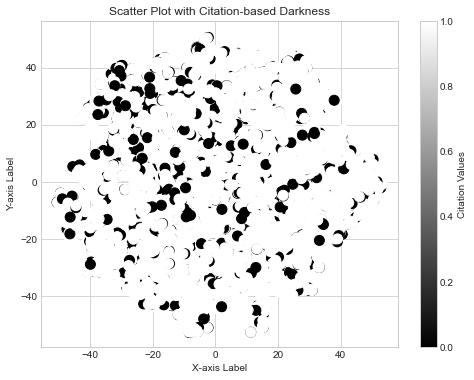

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example data for 't[0]' and 'citation'

# Example data for 'citation'


# Extract x and y coordinates from 't[0]'
x_coordinates = t[0][:, 0]
y_coordinates = t[0][:, 1]

# Create a scatter plot with 'citation' values determining point darkness
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

citation['citation'] = citation['n_citation'].clip(0, 1)

# Scatter plot with 'x_coordinates' as x-coordinates, 'y_coordinates' as y-coordinates, and 'citation' as darkness (cmap='gray' for grayscale)
plt.scatter(x_coordinates, y_coordinates, c=citation['citation'], cmap='gray', s=100) 

# Add color bar for reference
cbar = plt.colorbar()
cbar.set_label('Citation Values')

# Label the axes and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Citation-based Darkness')

# Show the plot
plt.show()


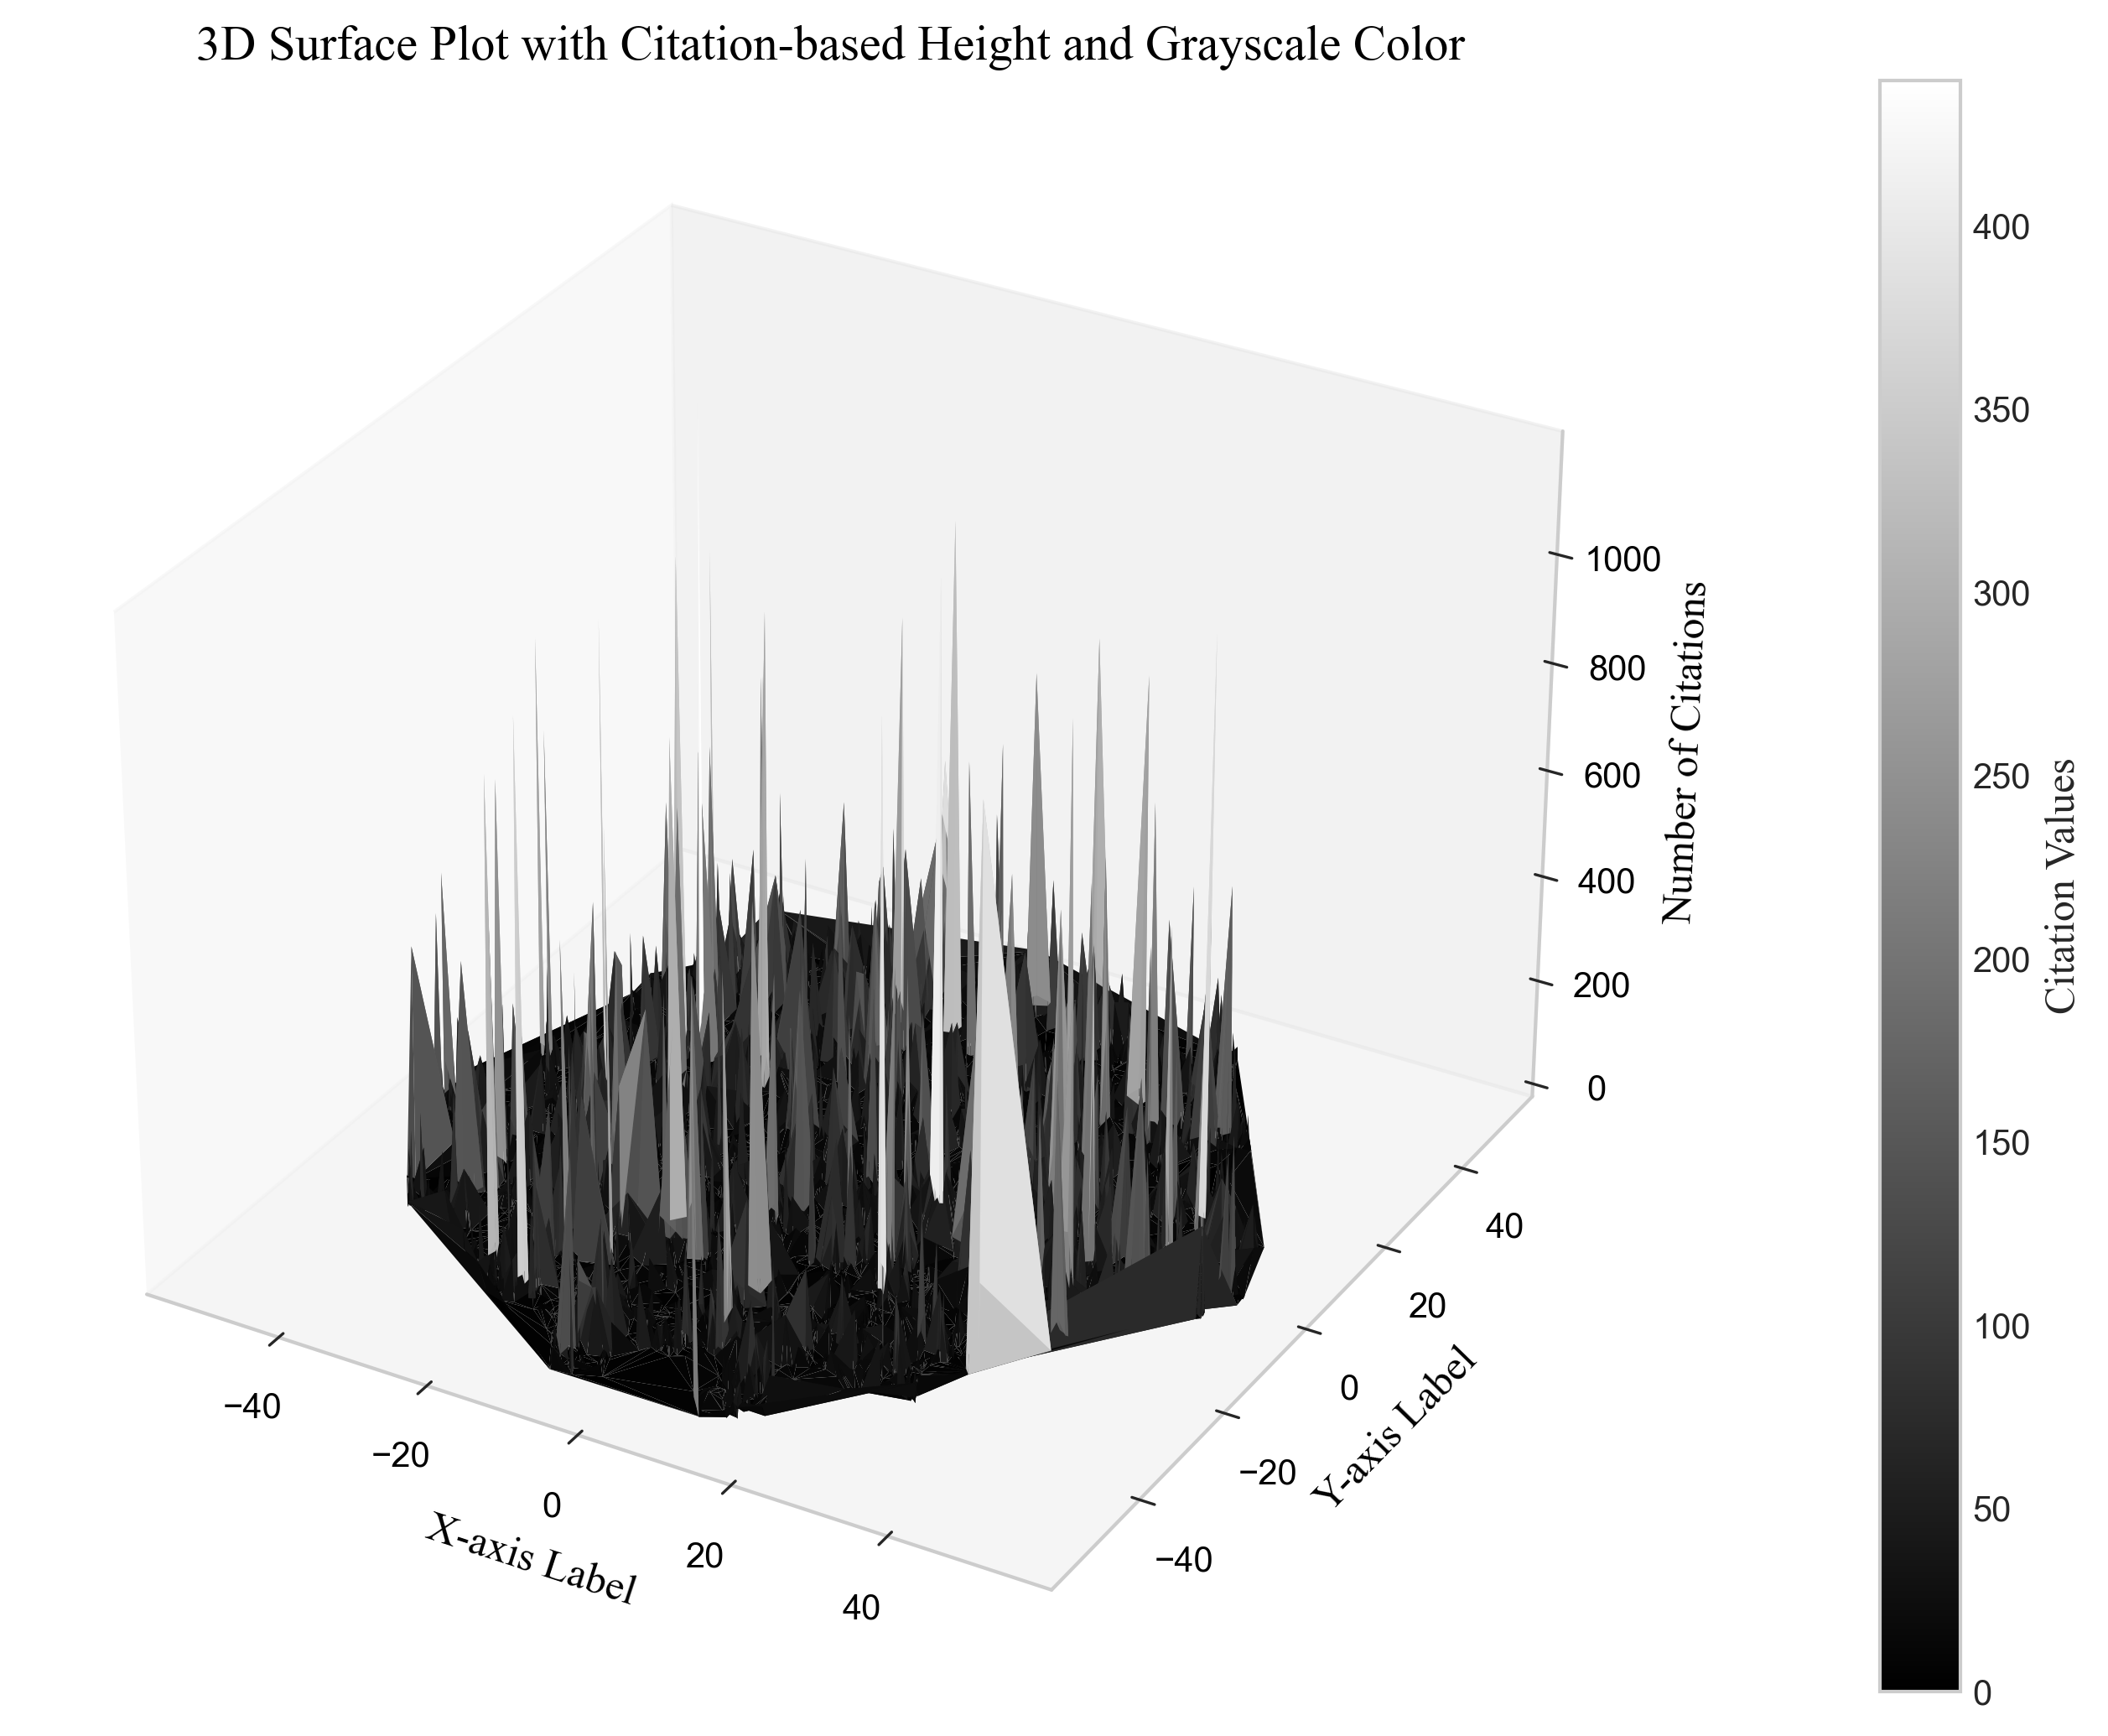

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load citation data
citation = pd.read_csv('ProcessedData/n_citation_data.csv')

# Extract x and y coordinates from 't[0]' for citations less than 12000000
x_coordinates = t[0][citation['n_citation'] < 1200, 0]
y_coordinates = t[0][citation['n_citation'] < 1200, 1]

# Filter citations to be less than 12000000
citation = citation[citation['n_citation'] < 1200]

# Create a 3D surface plot with 'n_citation' values determining point height
fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot with grayscale based on citation values
triang = ax.plot_trisurf(x_coordinates, y_coordinates, citation['n_citation'], cmap='gray', edgecolor='none')

# Add color bar for reference
cbar = plt.colorbar(triang, ax=ax, pad=0.1)
cbar.set_label('Citation Values', fontsize=12, fontname='Times New Roman')

# Label the axes and title in Times New Roman for APA style
ax.set_xlabel('X-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_ylabel('Y-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_zlabel('Number of Citations', fontsize=12, fontname='Times New Roman', color='black')
ax.set_title('3D Surface Plot with Citation-based Height and Grayscale Color', fontsize=14, fontname='Times New Roman', color='black')

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, labelcolor='black')
ax.tick_params(axis='z', which='major', labelsize=10, labelcolor='black')

# Remove gridlines
ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()




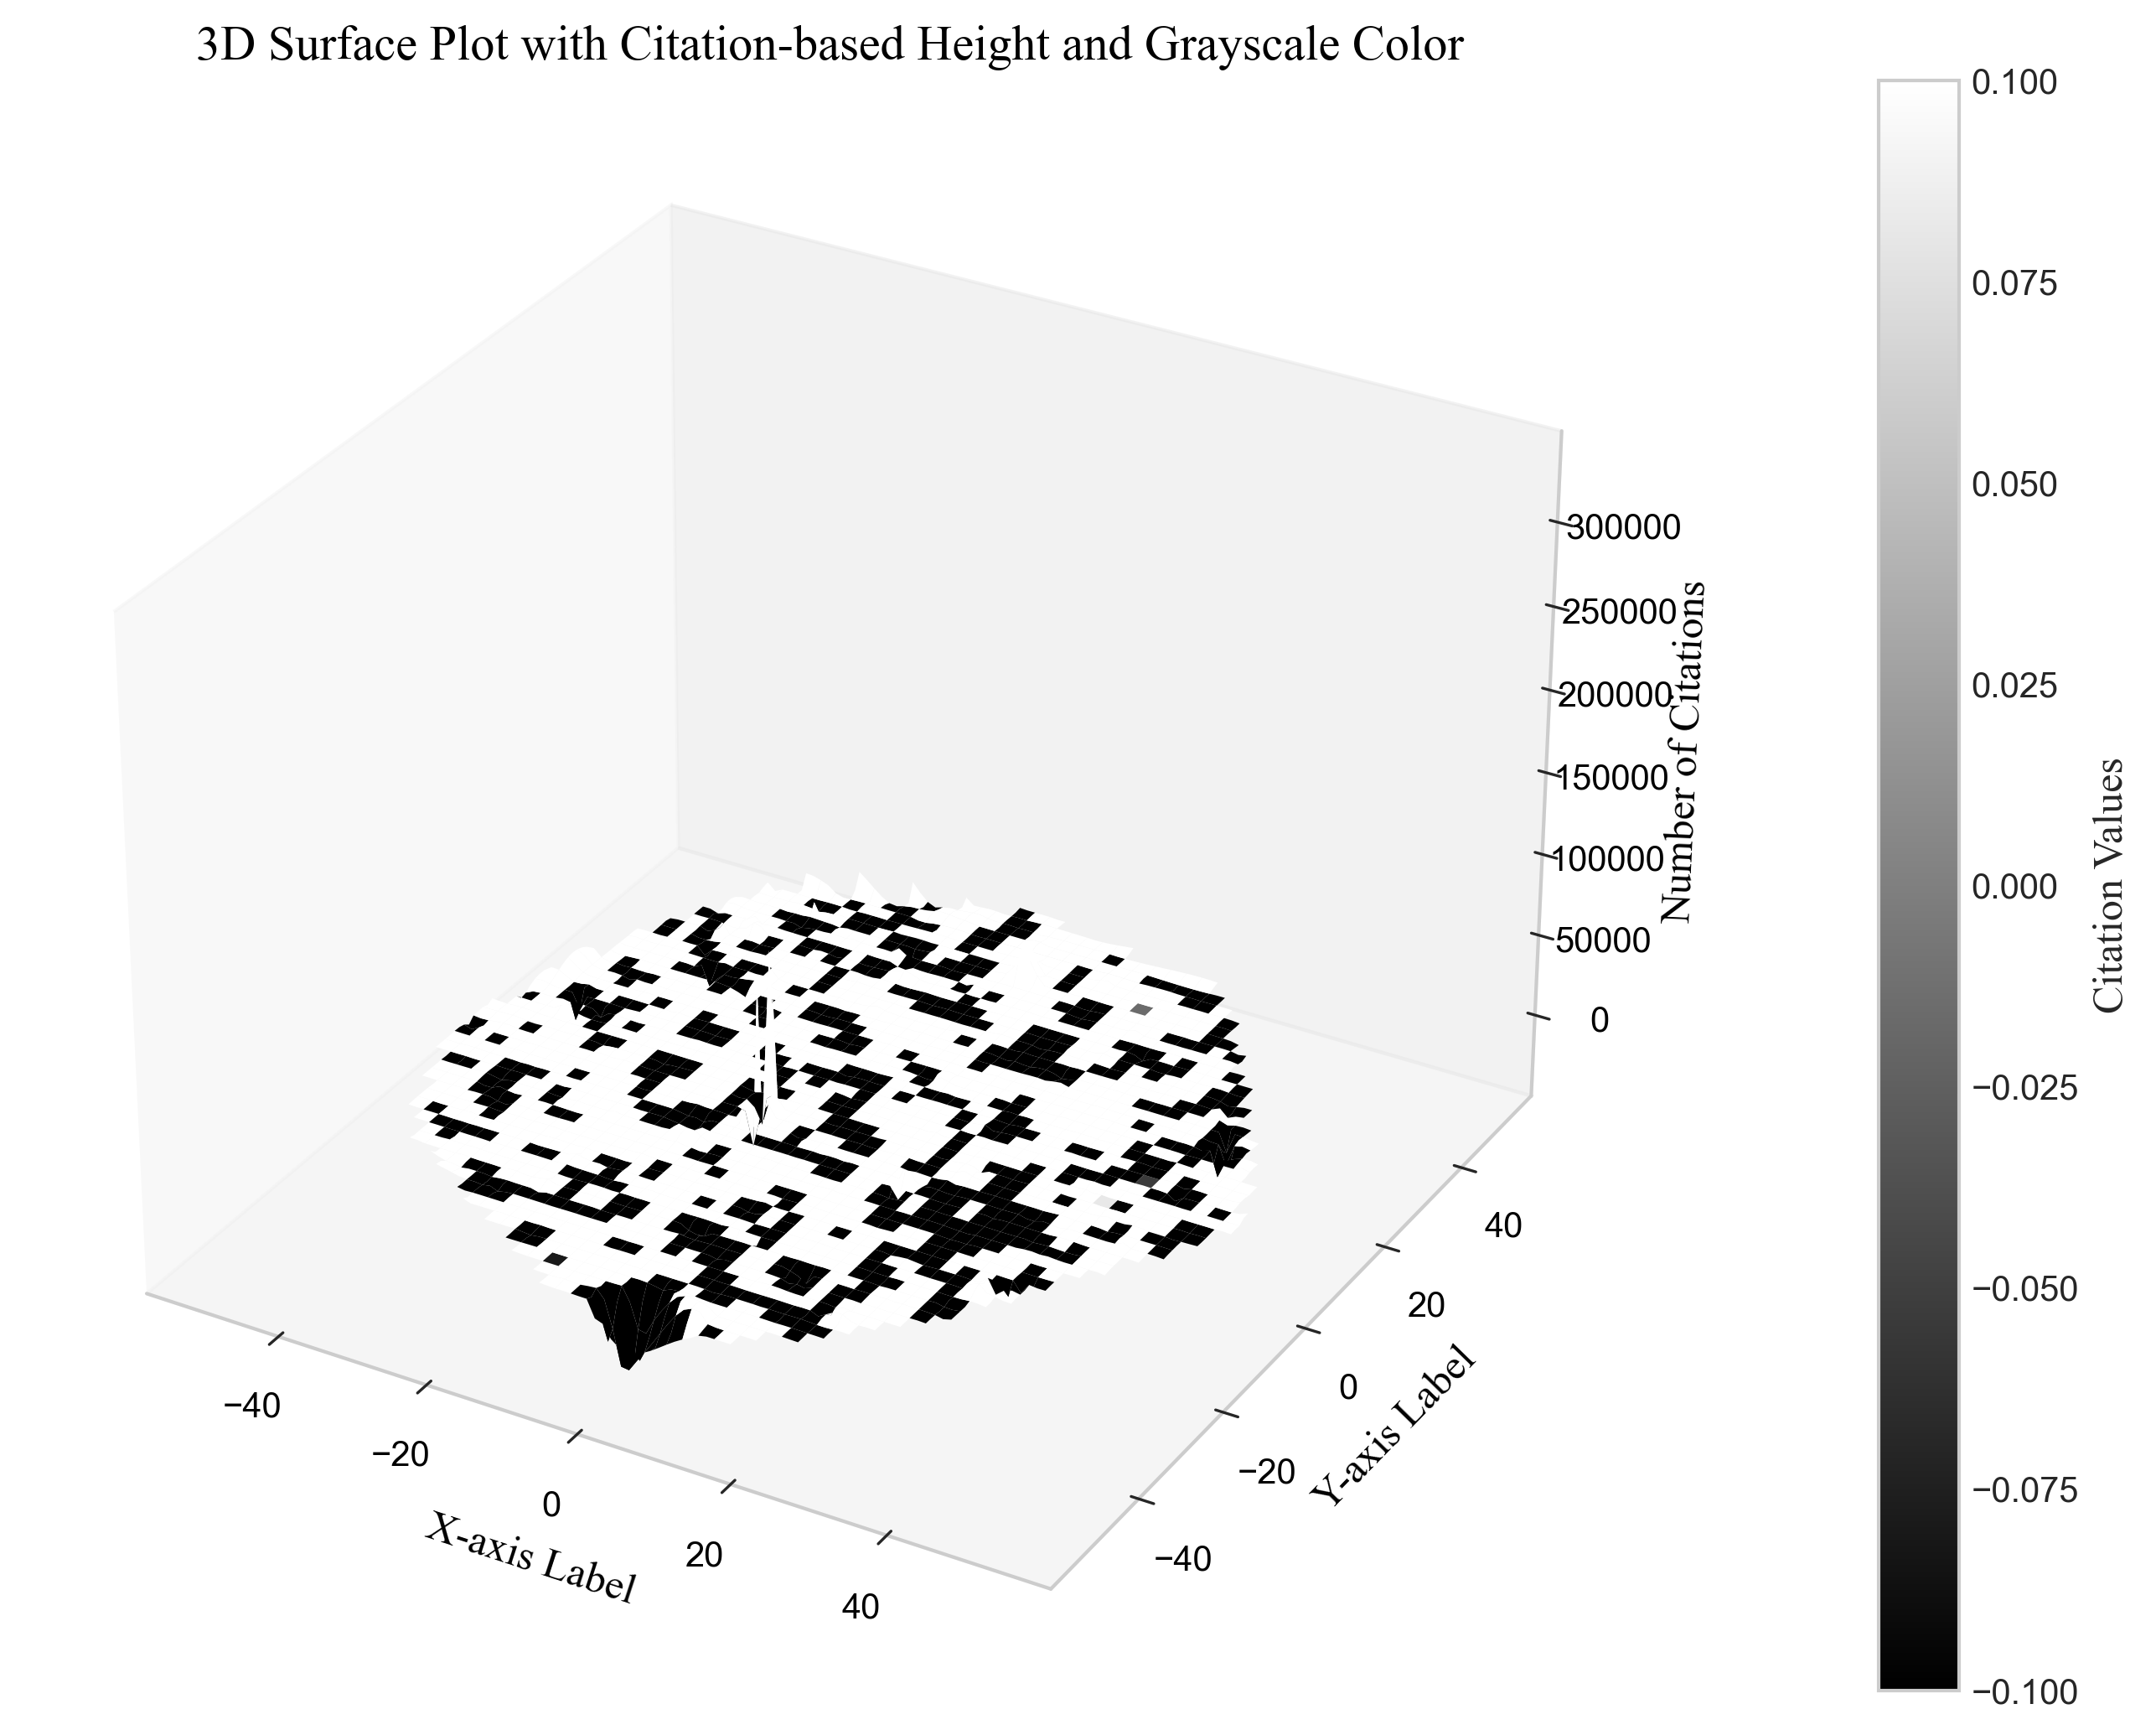

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Load citation data
citation = pd.read_csv('ProcessedData/n_citation_data.csv')

# Extract x and y coordinates from 't[0]' for citations less than 12000000
x_coordinates = t[0][citation['n_citation'] < 12000000, 0]
y_coordinates = t[0][citation['n_citation'] < 12000000, 1]

# Filter citations to be less than 12000000
citation = citation[citation['n_citation'] < 12000000]

# Interpolate to create a smooth surface
xi = np.linspace(x_coordinates.min(), x_coordinates.max(), 100)
yi = np.linspace(y_coordinates.min(), y_coordinates.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x_coordinates, y_coordinates), citation['n_citation'], (xi, yi), method='cubic')

# Create a 3D surface plot with interpolated values
fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Create a 3D surface plot with grayscale based on citation values
surf = ax.plot_surface(xi, yi, zi, cmap='gray', edgecolor='none')

# Add color bar for reference
cbar = plt.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label('Citation Values', fontsize=12, fontname='Times New Roman')

# Label the axes and title in Times New Roman for APA style
ax.set_xlabel('X-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_ylabel('Y-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_zlabel('Number of Citations', fontsize=12, fontname='Times New Roman', color='black')
ax.set_title('3D Surface Plot with Citation-based Height and Grayscale Color', fontsize=14, fontname='Times New Roman', color='black')

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, labelcolor='black')
ax.tick_params(axis='z', which='major', labelsize=10, labelcolor='black')

# Remove gridlines
ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()




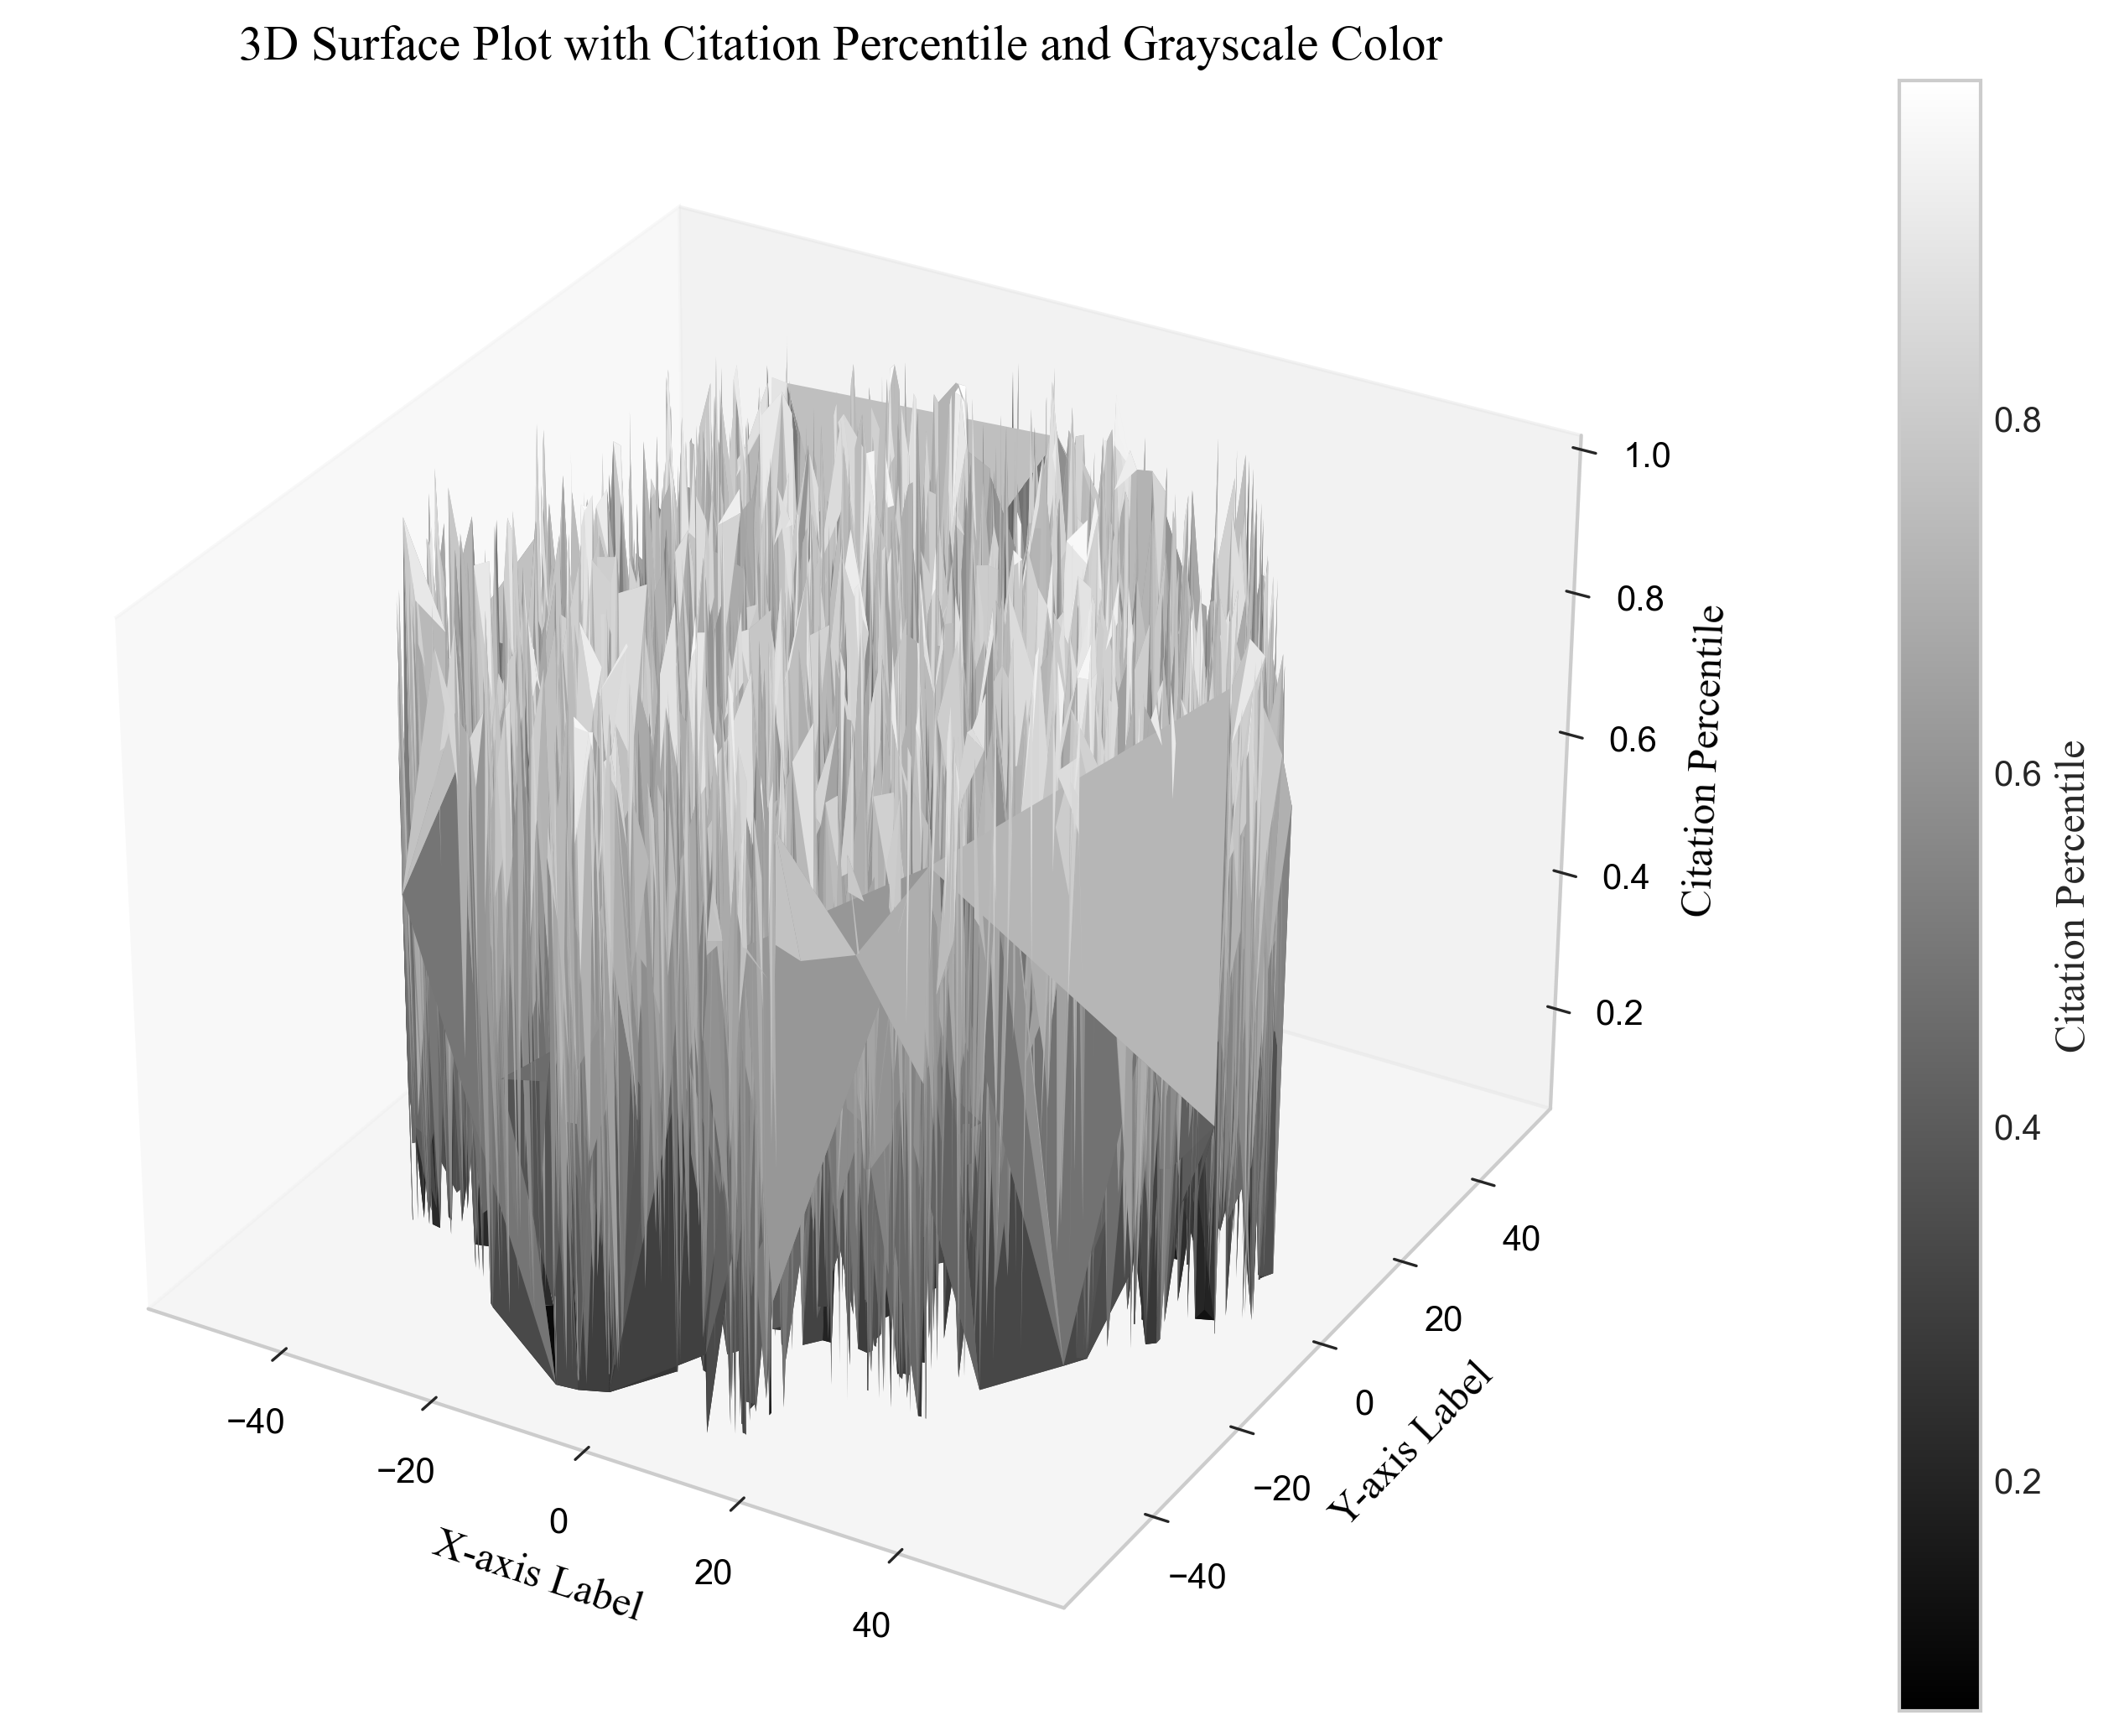

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Load citation data
citation = pd.read_csv('ProcessedData/n_citation_data.csv')

# Filter citations to be less than 1200
citation_filtered = citation[citation['n_citation'] < 1200]

# Calculate the percentiles of 'n_citation'
citation_filtered['citation_percentile'] = citation_filtered['n_citation'].rank(pct=True)

# Extract x and y coordinates from 't[0]' for citations less than 1200
x_coordinates = t[0][citation['n_citation'] < 1200, 0]
y_coordinates = t[0][citation['n_citation'] < 1200, 1]

# Create a 3D surface plot with 'citation_percentile' values determining point height and color
fig = plt.figure(figsize=(10, 7), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot with grayscale based on citation percentile values
triang = ax.plot_trisurf(x_coordinates, y_coordinates, citation_filtered['citation_percentile'], cmap='gray', edgecolor='none')

# Add color bar for reference
cbar = plt.colorbar(triang, ax=ax, pad=0.1)
cbar.set_label('Citation Percentile', fontsize=12, fontname='Times New Roman')

# Label the axes and title in Times New Roman for APA style
ax.set_xlabel('X-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_ylabel('Y-axis Label', fontsize=12, fontname='Times New Roman', color='black')
ax.set_zlabel('Citation Percentile', fontsize=12, fontname='Times New Roman', color='black')
ax.set_title('3D Surface Plot with Citation Percentile and Grayscale Color', fontsize=14, fontname='Times New Roman', color='black')

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, labelcolor='black')
ax.tick_params(axis='z', which='major', labelsize=10, labelcolor='black')

# Remove gridlines
ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


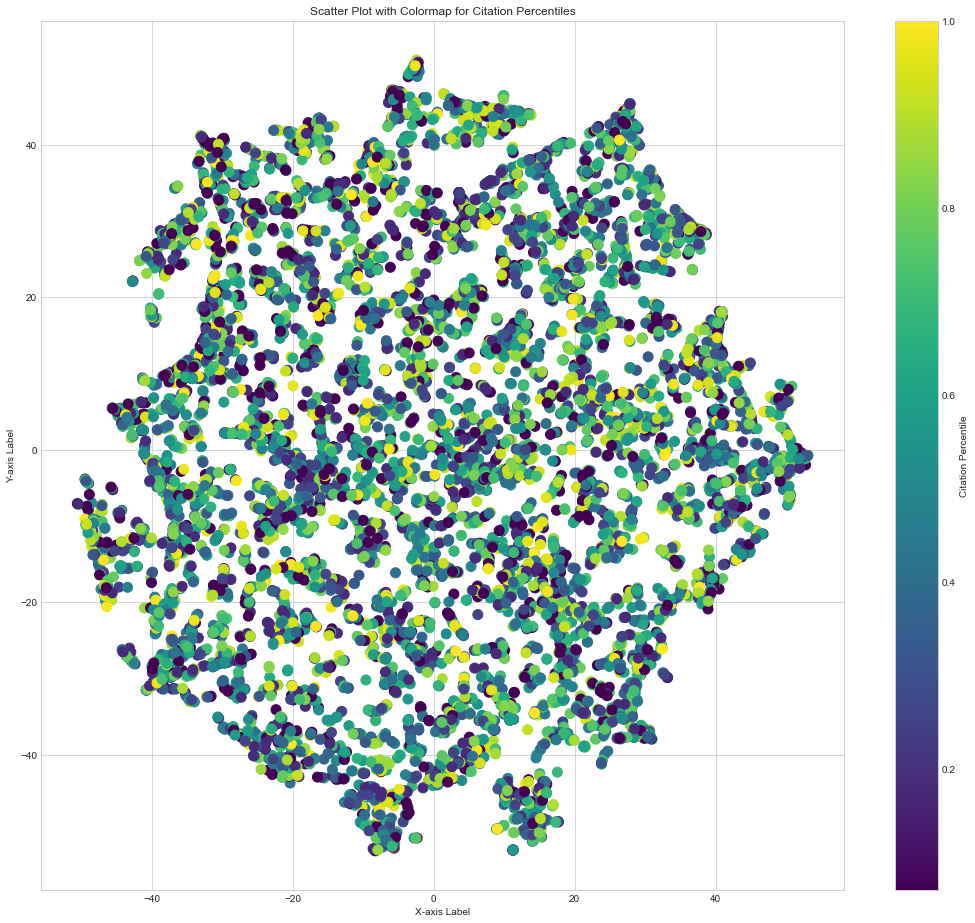

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Extract x and y coordinates from 't[0]'
x_coordinates = t[0][:, 0]
y_coordinates = t[0][:, 1]

# Calculate the percentiles of 'n_citation'
citation['citation_percentile'] = citation['n_citation'].rank(pct=True)

# Create a scatter plot with 'citation_percentile' values determining point colors using the "viridis" colormap
plt.figure(figsize=(18, 16))  # Adjust the figure size as needed

# Scatter plot with 'x_coordinates' as x-coordinates, 'y_coordinates' as y-coordinates, and 'citation_percentile' as colors (cmap='viridis')
scatter = plt.scatter(x_coordinates, y_coordinates, c=citation['citation_percentile'], cmap='viridis', s=100)

# Add color bar for reference
cbar = plt.colorbar(scatter)
cbar.set_label('Citation Percentile')

# Label the axes and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Colormap for Citation Percentiles')

# Show the plot
plt.show()

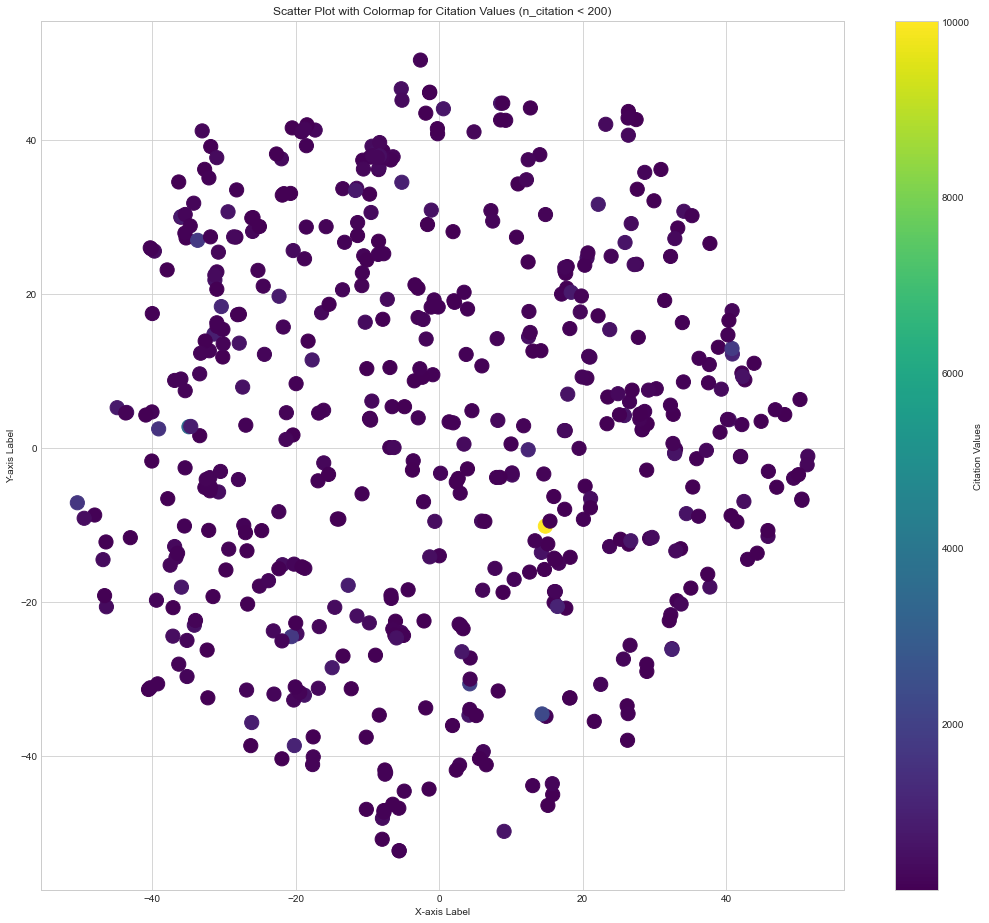

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example data for 't[0]' and 'citation'

# Example data for 'citation'
citation = pd.read_csv('ProcessedData/n_citation_data.csv')

# Filter records where 'n_citation' is less than 200
filtered_citation = citation[citation['n_citation'] > 100]

# Extract x and y coordinates from 't[0]'
x_coordinates = t[0][citation['n_citation'] > 100, 0]
y_coordinates = t[0][citation['n_citation'] > 100, 1]

# Create a scatter plot with 'citation' values determining point colors using the "viridis" colormap
plt.figure(figsize=(18, 16))

# Scatter plot with 'x_coordinates' as x-coordinates, 'y_coordinates' as y-coordinates, and 'citation' as colors (cmap='viridis')
plt.scatter(x_coordinates, y_coordinates, c=filtered_citation['n_citation'], cmap='viridis', s=200) 

# Add color bar for reference
cbar = plt.colorbar()
cbar.set_label('Citation Values')

# Label the axes and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Colormap for Citation Values (n_citation < 200)')

# Show the plot
plt.show()


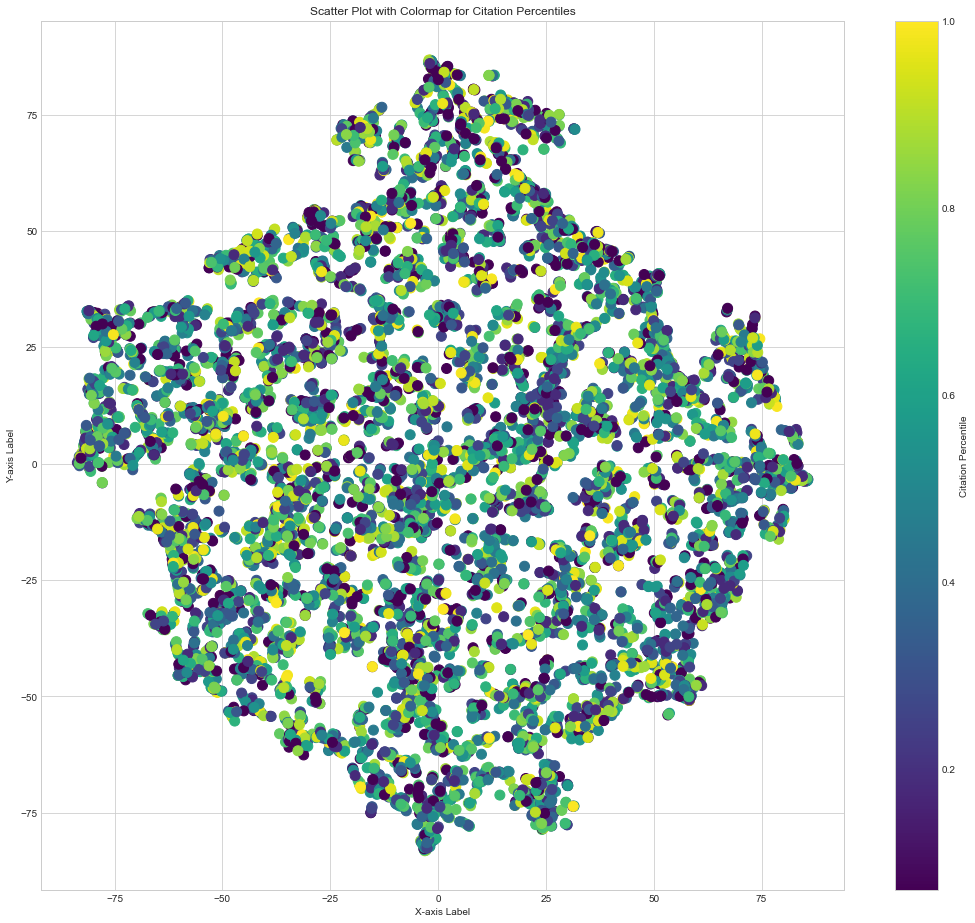

In [153]:
def plot_citation_percentiles(lda_model, corpus, n_citation):
    # Ensure the input is a DataFrame
    citation = pd.DataFrame({'n_citation': n_citation})

    # Calculate the topic distribution for each document in the corpus
    topic_distributions = []
    for doc in corpus:
        topic_distribution = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_distributions.append([prob for _, prob in topic_distribution])

    # Convert to NumPy array
    topic_distributions = np.array(topic_distributions)

    # Perform t-SNE on the topic distributions
    tsne_model = TSNE(n_components=2, random_state=42)
    t = tsne_model.fit_transform(topic_distributions)

    # Extract x and y coordinates from the t-SNE result
    x_coordinates = t[:, 0]
    y_coordinates = t[:, 1]

    # Calculate the percentiles of 'n_citation'
    citation['citation_percentile'] = citation['n_citation'].rank(pct=True)

    # Create a scatter plot with 'citation_percentile' values determining point colors using the "viridis" colormap
    plt.figure(figsize=(18, 16))  # Adjust the figure size as needed

    # Scatter plot with 'x_coordinates' as x-coordinates, 'y_coordinates' as y-coordinates, and 'citation_percentile' as colors (cmap='viridis')
    scatter = plt.scatter(x_coordinates, y_coordinates, c=citation['citation_percentile'], cmap='viridis', s=100)

    # Add color bar for reference
    cbar = plt.colorbar(scatter)
    cbar.set_label('Citation Percentile')

    # Label the axes and title
    plt.xlabel('t-sne dimension 1')
    plt.ylabel('t-sne dimension 2')
    plt.title('Scatter Plot with Colormap for Citation Percentiles')

    # Show the plot
    plt.show()

plot_citation_percentiles(lda_model, corpus, citation["n_citation"])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8842 samples in 0.084s...
[t-SNE] Computed neighbors for 8842 samples in 2.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8842
[t-SNE] Computed conditional probabilities for sample 2000 / 8842
[t-SNE] Computed conditional probabilities for sample 3000 / 8842
[t-SNE] Computed conditional probabilities for sample 4000 / 8842
[t-SNE] Computed conditional probabilities for sample 5000 / 8842
[t-SNE] Computed conditional probabilities for sample 6000 / 8842
[t-SNE] Computed conditional probabilities for sample 7000 / 8842
[t-SNE] Computed conditional probabilities for sample 8000 / 8842
[t-SNE] Computed conditional probabilities for sample 8842 / 8842
[t-SNE] Mean sigma: 0.104717
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.095589
[t-SNE] KL divergence after 1000 iterations: 1.801137


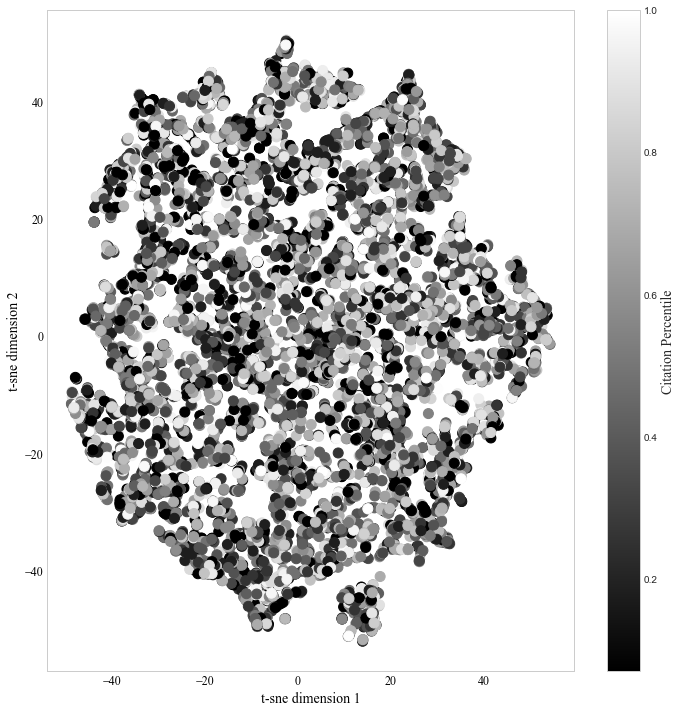

In [159]:
def plot_citation_percentiles(lda_model, corpus, n_citation, color='viridis', file=''):
    # Ensure the input is a DataFrame
    citation = pd.DataFrame({'n_citation': n_citation})
    
    # Get the t-SNE outcome and topic numbers
    tsne_outcome, topic_num = createtsne(lda_model, corpus)

    # Extract x and y coordinates from the t-SNE result
    x_coordinates = tsne_outcome[:, 0]
    y_coordinates = tsne_outcome[:, 1]
    
    # Calculate the percentiles of 'n_citation'
    citation['citation_percentile'] = citation['n_citation'].rank(pct=True)
    
    # Determine the colormap based on the color input
    cmap = 'gray' if color == 'gray' else 'viridis'
    
    # Create a scatter plot with 'citation_percentile' values determining point colors
    plt.figure(figsize=(10, 10))  # A4 size in inches (portrait orientation)
    
    # Scatter plot with 'x_coordinates' as x-coordinates, 'y_coordinates' as y-coordinates, and 'citation_percentile' as colors (cmap)
    scatter = plt.scatter(x_coordinates, y_coordinates, c=citation['citation_percentile'], cmap=cmap, s=100)
    
    # Add color bar for reference
    cbar = plt.colorbar(scatter)
    cbar.set_label('Citation Percentile', fontsize=14, fontname='Times New Roman')
    
    # Label the axes and title in Times New Roman for APA style
    plt.xlabel('t-sne dimension 1', fontsize=14, fontname='Times New Roman', color='black')
    plt.ylabel('t-sne dimension 2', fontsize=14, fontname='Times New Roman', color='black')
    plt.title('', fontsize=16, fontname='Times New Roman', color='black')
    
    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    
    # Set font properties for APA style
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    
    # Remove gridlines
    plt.grid(False)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save the plot if a file name is provided
    if file:
        plt.savefig(file, format='png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

plot_citation_percentiles(lda_model, corpus, citation["n_citation"],color='gray',file='Graphs/LDA/lda_citation_percentiles.png')

In [142]:
citation = pd.read_csv('ProcessedData/n_citation_data.csv')
topics = topics_per_document(lda_model, corpus)
dominant = [point[1] for point in topics[0]]
citation['dominant']=pd.DataFrame(dominant)
citation

n_citation  dominant
0              0         2
1              0         8
2             10         7
3             28         0
4              3         8
...          ...       ...
8837           4         3
8838           2         2
8839           1         0
8840           7        18
8841         176        13

[8842 rows x 2 columns]

In [150]:
topics[1][2310]

[(0, 0.21910566),
 (3, 0.023168297),
 (7, 0.14923424),
 (8, 0.34562266),
 (11, 0.05981003),
 (17, 0.1952654)]

In [140]:
topics[0][0]

(0, 11)

In [61]:
mean_by_dominant = citation.groupby('dominant')['n_citation'].mean()

# Display the result
print(mean_by_dominant)

dominant
0     37.195858
1     23.227273
2     29.338736
3     51.754950
4     19.684564
5     32.205788
6     31.215686
7     37.204694
8     28.133333
9     11.907143
10    26.000000
11    30.840237
12    19.530928
13    29.283816
14    23.757709
15    33.535912
16    22.044444
17    34.869159
18    20.839679
19    22.057692
Name: n_citation, dtype: float64


In [62]:
citation.groupby('dominant')['n_citation'].count()

dominant
0     1159
1       66
2     1234
3      404
4      149
5      311
6      255
7      767
8      930
9      140
10      48
11     169
12     194
13     828
14     681
15     181
16      90
17     321
18     499
19     416
Name: n_citation, dtype: int64

     feature           VIF
0      const  13759.002211
1    topic_0    599.781680
2    topic_1     40.428041
3    topic_2    600.188739
4    topic_3    204.177214
5    topic_4     93.343202
6    topic_5    167.572287
7    topic_6    143.367405
8    topic_7    374.422696
9    topic_8    470.607933
10   topic_9     85.379518
11  topic_10     32.573883
12  topic_11    101.404371
13  topic_12    100.129695
14  topic_13    414.975805
15  topic_14    345.421780
16  topic_15     91.319638
17  topic_16     57.026647
18  topic_17    175.000068
19  topic_18    267.466788
20  topic_19    222.604674
Ridge Regression R^2: 0.0020653132711616617
Lasso Regression R^2: 0.0021372795594856164


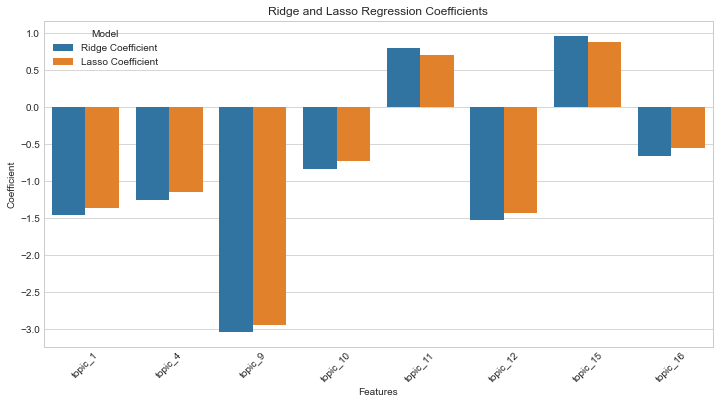

In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Example loading data (replace with your actual data)


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(topics[1]), num_topics))

for i, doc in enumerate(topics[1]):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Example citation data (replace with your actual data)


# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation', 'dominant'])
y = data['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Check for multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Remove predictors with high VIF values (e.g., VIF > 10)
high_vif_features = vif_data[vif_data["VIF"] > 105]["feature"]
X_reduced = X.drop(columns=high_vif_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Standardize the data for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Apply Lasso regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the models
print(f"Ridge Regression R^2: {r2_score(y_test, y_pred_ridge)}")
print(f"Lasso Regression R^2: {r2_score(y_test, y_pred_lasso)}")

# Plot the coefficients from Ridge and Lasso regression
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Ridge Coefficient': ridge.coef_,
    'Lasso Coefficient': lasso.coef_
})
coef_df = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_df)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Ridge and Lasso Regression Coefficients')
plt.show()


In [87]:
citation

n_citation  dominant
0              0         2
1              0         8
2             10         7
3             28         0
4              3         8
...          ...       ...
8837           4         3
8838           2         2
8839           1         0
8840           7        18
8841         176        13

[8842 rows x 2 columns]

Original Skewness: 43.067564282507604
Log-transformed Skewness: 0.35857121470776276


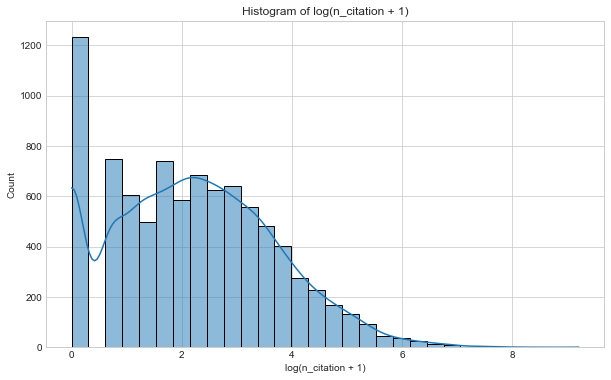

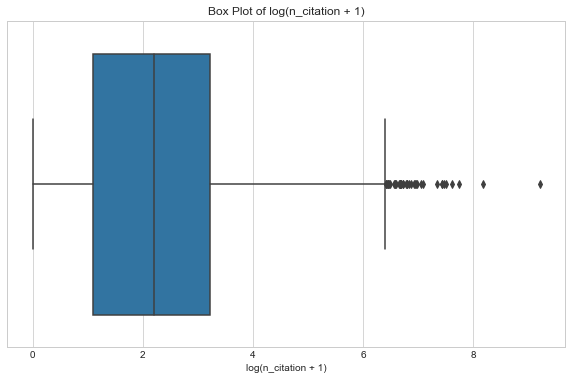

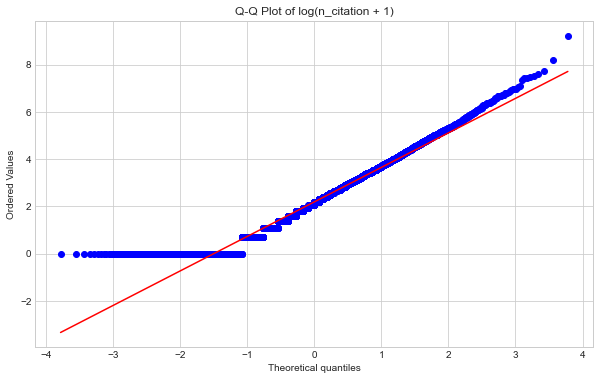

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, probplot



# Extract the dependent variable
y = citation['n_citation']

# Original Skewness
original_skewness = skew(y)
print(f'Original Skewness: {original_skewness}')

# 1. Apply Log Transformation
y_log = np.log1p(y)  # log1p is used to handle zero values by applying log(1 + y)

# 2. Re-check Skewness
log_skewness = skew(y_log)
print(f'Log-transformed Skewness: {log_skewness}')

# 3. Visualize the log-transformed distribution

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_log, kde=True, bins=30)
plt.xlabel('log(n_citation + 1)')
plt.title('Histogram of log(n_citation + 1)')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(y_log)
plt.xlabel('log(n_citation + 1)')
plt.title('Box Plot of log(n_citation + 1)')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
probplot(y_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of log(n_citation + 1)')
plt.show()


Ridge Regression R^2: 0.02546782344664944
Lasso Regression R^2: -0.0010503985723790965


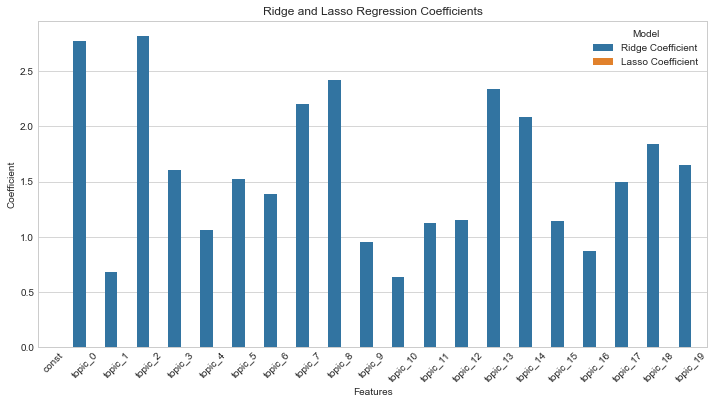

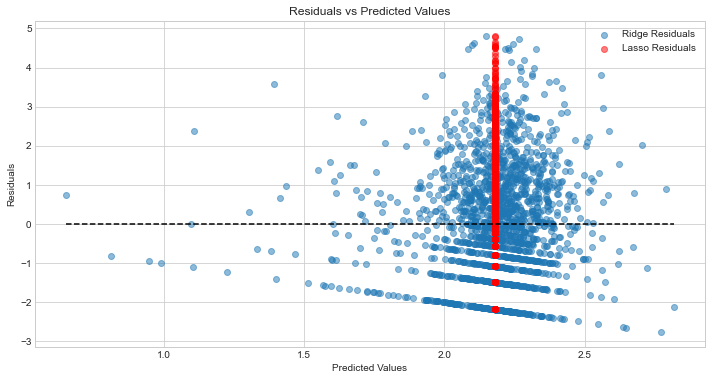

In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Example loading data (replace with your actual data)


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(topics[1]), num_topics))

for i, doc in enumerate(topics[1]):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Example citation data (replace with your actual data)


# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation', 'dominant'])
y = data['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Log-transform the dependent variable
y_log = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize the data for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Apply Lasso regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the models
print(f"Ridge Regression R^2: {r2_score(y_test, y_pred_ridge)}")
print(f"Lasso Regression R^2: {r2_score(y_test, y_pred_lasso)}")

# Evaluate the residuals
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

# Plot the coefficients from Ridge and Lasso regression
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Ridge Coefficient': ridge.coef_,
    'Lasso Coefficient': lasso.coef_
})
coef_df = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_df)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Ridge and Lasso Regression Coefficients')
plt.show()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5, label='Ridge Residuals')
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5, label='Lasso Residuals', color='red')
plt.hlines(0, min(y_pred_ridge), max(y_pred_ridge), colors='black', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.57
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           2.33e-37
Time:                        14:35:56   Log-Likelihood:                -15922.
No. Observations:                8842   AIC:                         3.189e+04
Df Residuals:                    8821   BIC:                         3.203e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.4950      1.829    -11.208      0.0

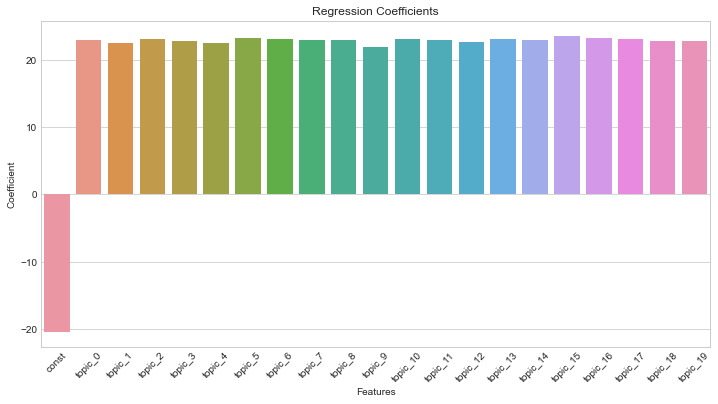

In [96]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Example loading data and citation data (replace with your actual data)
loading = topics[1]

# Example citation data


# Convert the loading data to a DataFrame
num_topics = 20  # Assume there are 20 topics
data = np.zeros((len(loading), num_topics))

for i, doc in enumerate(loading):
    for topic, load in doc:
        data[i, topic] = load

loading_df = pd.DataFrame(data, columns=[f'topic_{i}' for i in range(num_topics)])

# Combine the topic loadings and citations into a single DataFrame
data = pd.concat([loading_df, citation], axis=1)

# Prepare the independent variables (X) and dependent variable (y)
X = data.drop(columns=['n_citation','dominant'])
y = data['n_citation']
y_log = np.log1p(y)

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y_log, X).fit()

# Print the summary of the regression results
print(model.summary())

# Visualize the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=model.params.index, y=model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.005
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           1.16e-05
Time:                        14:39:14   Log-Likelihood:                -16008.
No. Observations:                8842   AIC:                         3.206e+04
Df Residuals:                    8822   BIC:                         3.220e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1813      0.044     50.040      

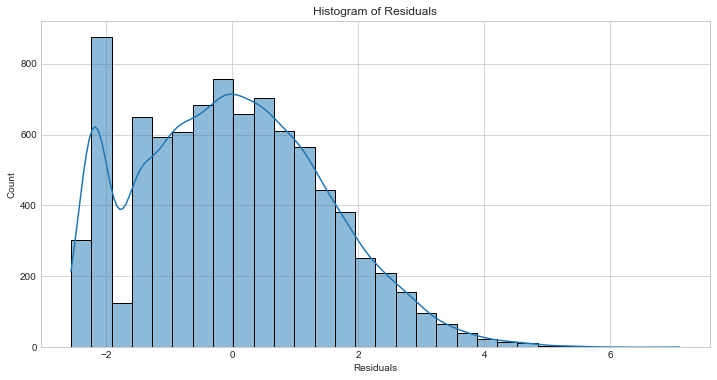

<Figure size 864x432 with 0 Axes>

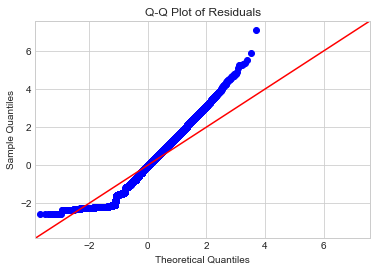

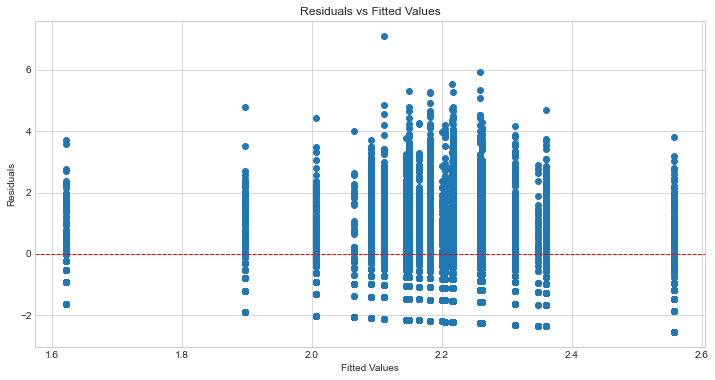

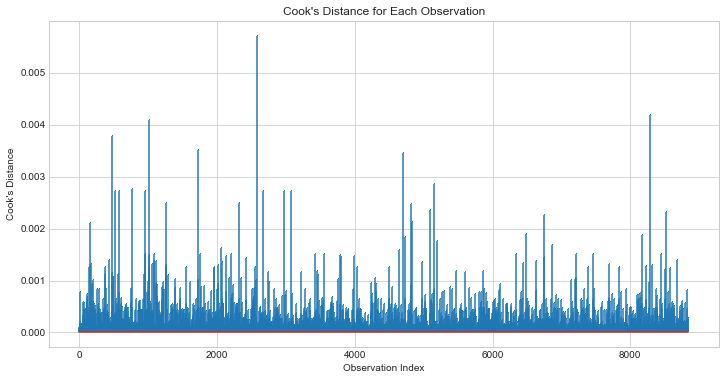

Influential points: [   9   55   66   86  107  109  116  126  133  150  172  175  182  191
  199  206  230  254  277  291  339  360  366  378  381  402  436  468
  476  483  486  488  520  533  552  561  564  577  582  602  607  619
  665  672  675  687  699  750  756  760  762  824  860  869  886  926
  934  953  956  983 1001 1004 1008 1017 1029 1044 1061 1079 1086 1108
 1118 1122 1123 1134 1136 1153 1203 1205 1211 1219 1233 1255 1256 1260
 1264 1265 1291 1324 1341 1348 1374 1388 1392 1394 1415 1455 1459 1462
 1491 1549 1553 1562 1610 1644 1666 1688 1718 1724 1727 1747 1749 1773
 1777 1790 1807 1826 1871 1906 1957 1959 1996 2007 2011 2021 2062 2064
 2075 2076 2077 2086 2088 2091 2124 2130 2168 2196 2205 2218 2221 2237
 2240 2275 2279 2283 2287 2295 2322 2324 2352 2364 2419 2426 2513 2519
 2524 2535 2542 2551 2572 2578 2617 2623 2663 2690 2741 2751 2826 2848
 2851 2867 2899 2939 2975 2981 3000 3072 3087 3148 3215 3261 3283 3300
 3342 3352 3426 3450 3464 3487 3503 3518 3519 3534 3558 3

AttributeError: module 'statsmodels.api' has no attribute 'robust_norms'

In [98]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, probplot


# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation['n_citation']

# Log-transform the dependent variable
y_log = np.log1p(y)

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y_log, X).fit()

# Print the summary of the regression results
print(model.summary())

# Evaluate the residuals
residuals = model.resid

# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q Plot of residuals
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Residuals vs Fitted values plot
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Check for outliers using Cook's distance
influence = model.get_influence()
(c, p) = influence.cooks_distance

# Plot Cook's distance
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

# Identify high Cook's distance points
influential_points = np.where(c > 4/len(c))[0]
print("Influential points:", influential_points)

# Remove influential points and refit the model
X_influential = X.drop(index=influential_points)
y_log_influential = y_log.drop(index=influential_points)

model_influential = sm.OLS(y_log_influential, X_influential).fit()

# Print the summary of the regression results after removing influential points
print(model_influential.summary())

# Robust regression
robust_model = sm.RLM(y_log, X, M=sm.robust_norms.HuberT()).fit()
print(robust_model.summary())

# Visualize the coefficients from the robust regression
plt.figure(figsize=(12, 6))
sns.barplot(x=robust_model.params.index, y=robust_model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Robust Regression Coefficients')
plt.show()


In [127]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.robust.norms import HuberT



# Filter records where the number of citations is less than 100
citation_filtered = citation[citation['n_citation'] >50]

# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation_filtered, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation_filtered['n_citation']

# Log-transform the dependent variable
y_log = y

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the initial linear regression model
initial_model = sm.OLS(y_log, X).fit()

print(initial_model.summary())




KeyError: "None of [Index(['dominant'], dtype='object')] are in the [columns]"

                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8480
Date:                Sun, 21 Jul 2024   Prob (F-statistic):              0.650
Time:                        14:26:44   Log-Likelihood:                -56395.
No. Observations:                8842   AIC:                         1.128e+05
Df Residuals:                    8822   BIC:                         1.130e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.8848      7.298      2.588      

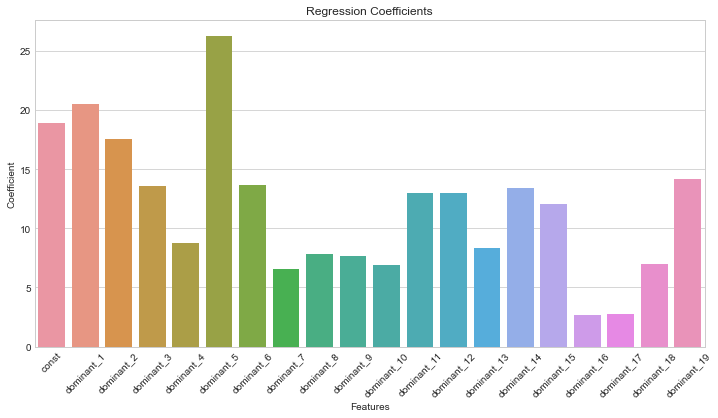

In [90]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns



# One-hot encode the categorical variable 'dominant'
citation_encoded = pd.get_dummies(citation, columns=['dominant'], drop_first=True)

# Prepare the independent variables (X) and dependent variable (y)
X = citation_encoded.drop(columns=['n_citation'])
y = citation['n_citation']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

# Visualize the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=model.params.index, y=model.params.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')
plt.show()